In [1]:
#pip install seaborn
#!pip install scikit-optimize

**Details of the analysis in this notebook**

Part 1: Feature ablation
- Created 4 sets of data (X_, X_2, X_3, X_4), each with reduced number of features to improve the model performance
    - X_ = all features
    - X_2 = drop position ratings
    - X_3 = drop features based on correlations
    - X_4 = drop features based on correlations
- Each set of data is used in a standard LogisticRegression, GradientBoostingClassifier and GaussianNB, with evaluation metrics (accuracy, recall, precision and F1) on both training and test data

Part 2: Important tradeoffs (2 separate tradeoffs analyzed)
- (a: time vs accuracy) Compared the time required to compute the evaluation metrics between dataset X_ and X_4 (reduced number of features) 
- (b: data size vs accuracy) Compared the evaluation metrics of the models when we include teams in all league (X_4) vs. teams in league_level=1 (top tier league) only (X1_4), we only compare two sets of data with reduced features
    - X1_ = all features (league_level = 1 only)
    - X1_2 = drop position ratings (league_level = 1 only)
    - X1_3 = drop features based on correlations (league_level = 1 only)
    - X1_4 = drop features based on correlations (league_level = 1 only)

Part 3: Sensitivity analysis
- In each of the model, we tuned at least 1 parameters and compared the evaluation metrics
- LogisticRegressionn: C=0.001, C=0.01, C=0.1, C=1
- GradientBoostingClassifier: Firstly, we tuned with learning_rate=0.0001, learning_rate=0.001, learning_rate=0.01, learning_rate=0.1, all with max_depth=3. Secondly, we picked learning_rate=0.001 to be the best parameter, then tuned with max_depth=3, max_depth=4, max_depth=5, max_depth=6
- GaussianNB: var_smoothing = 0.00001, var_smoothing = 0.0001, var_smoothing = 0.001, var_smoothing = 0.01
- *Part 1 can also be used for sensitivity analysis*

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import collections
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import time

In [3]:
df = pd.read_csv("final_data/fifa_cleaned_all_columns.csv")
df.head()

,Unnamed: 0,sofifa_id,short_name,player_positions,overall,potential,value_eur,wage_eur,age,height_cm,...,body_Stocky,body_Unique,right_foot,left_foot,injury_risk,teamwork,passing_traits,attacking_traits,dribbling_traits,defending_traits
0,0,158023,L. Messi,CF,93,95,100500000.0,550000.0,27,169,...,0,0,3,5,0,1,0,1,1,0
1,1,20801,Cristiano Ronaldo,"LW, LM",92,92,79000000.0,375000.0,29,185,...,0,0,5,4,0,0,0,1,1,0
2,2,9014,A. Robben,"RM, LM, RW",90,90,54500000.0,275000.0,30,180,...,0,0,2,5,1,-1,0,2,1,0
3,3,41236,Z. Ibrahimović,ST,90,90,52500000.0,275000.0,32,195,...,0,0,5,4,0,1,0,1,1,0
4,5,41,Iniesta,"CM, LW",89,89,36000000.0,250000.0,30,170,...,0,0,5,4,0,0,1,1,1,0


In [4]:
df['club_season'] = df.club_name.astype(str) + " " + df.season.astype(str)
df.player_positions = df.player_positions.apply(lambda x: x.split(',')[0])
df["new_pos"] = df.player_positions.apply(lambda x: "D" if x in ['LWB', 'LB', 'LCB', 'CB', 'RCB', 'RB', 'RWB']
                                                else "ND")
df.head()

,Unnamed: 0,sofifa_id,short_name,player_positions,overall,potential,value_eur,wage_eur,age,height_cm,...,right_foot,left_foot,injury_risk,teamwork,passing_traits,attacking_traits,dribbling_traits,defending_traits,club_season,new_pos
0,0,158023,L. Messi,CF,93,95,100500000.0,550000.0,27,169,...,3,5,0,1,0,1,1,0,FC Barcelona 1415,ND
1,1,20801,Cristiano Ronaldo,LW,92,92,79000000.0,375000.0,29,185,...,5,4,0,0,0,1,1,0,Real Madrid CF 1415,ND
2,2,9014,A. Robben,RM,90,90,54500000.0,275000.0,30,180,...,2,5,1,-1,0,2,1,0,FC Bayern München 1415,ND
3,3,41236,Z. Ibrahimović,ST,90,90,52500000.0,275000.0,32,195,...,5,4,0,1,0,1,1,0,Paris Saint-Germain 1415,ND
4,5,41,Iniesta,CM,89,89,36000000.0,250000.0,30,170,...,5,4,0,0,1,1,1,0,FC Barcelona 1415,ND


In [5]:
#Get all the defenders 
df_def = df[df.new_pos == 'D'].groupby('club_season').head(8).reset_index(drop=True).sort_values(by=['overall'], 
                                                                                                       ascending=False)
df_def.head()

,Unnamed: 0,sofifa_id,short_name,player_positions,overall,potential,value_eur,wage_eur,age,height_cm,...,right_foot,left_foot,injury_risk,teamwork,passing_traits,attacking_traits,dribbling_traits,defending_traits,club_season,new_pos
18986,3,155862,Sergio Ramos,CB,91,91,51000000.0,375000.0,32,184,...,5,3,0,2,0,0,0,2,Real Madrid CF 1819,D
24034,8,203376,V. van Dijk,CB,90,91,78000000.0,200000.0,27,193,...,5,3,-1,1,1,0,0,1,Liverpool 1920,D
9005,7,183907,J. Boateng,CB,90,90,56000000.0,200000.0,27,192,...,5,4,0,0,1,0,0,0,FC Bayern München 1617,D
29212,7,203376,V. van Dijk,CB,90,91,113000000.0,210000.0,28,193,...,5,3,-1,1,1,0,0,1,Liverpool 2021,D
13957,6,155862,Sergio Ramos,CB,90,90,52000000.0,300000.0,31,183,...,5,3,0,1,0,0,0,2,Real Madrid CF 1718,D


In [6]:
df_def.groupby('club_season').count().club_name.describe()

count    5153.000000
mean        7.745197
std         0.646365
min         0.000000
25%         8.000000
50%         8.000000
75%         8.000000
max         8.000000
Name: club_name, dtype: float64

In [7]:
df_notdef = df[df.new_pos == 'ND'].groupby('club_season').head(12).reset_index(drop=True).sort_values(
                                         by=['overall'], ascending=False)
df_notdef.head()

,Unnamed: 0,sofifa_id,short_name,player_positions,overall,potential,value_eur,wage_eur,age,height_cm,...,right_foot,left_foot,injury_risk,teamwork,passing_traits,attacking_traits,dribbling_traits,defending_traits,club_season,new_pos
21507,0,20801,Cristiano Ronaldo,LW,94,94,95500000.0,575000.0,32,185,...,5,4,0,0,1,1,1,0,Real Madrid CF 1718,ND
6930,0,158023,L. Messi,RW,94,95,111000000.0,550000.0,28,170,...,4,5,0,1,0,1,1,0,FC Barcelona 1516,ND
29239,0,20801,Cristiano Ronaldo,ST,94,94,77000000.0,400000.0,33,187,...,5,4,0,0,1,1,1,0,Juventus 1819,ND
29240,1,158023,L. Messi,CF,94,94,110500000.0,575000.0,31,170,...,4,5,0,0,1,3,1,0,FC Barcelona 1819,ND
13954,0,20801,Cristiano Ronaldo,LW,94,94,87000000.0,575000.0,31,185,...,5,4,0,0,0,1,1,0,Real Madrid CF 1617,ND


In [8]:
df_notdef.groupby('club_season').count().club_name.describe()

count    5153.000000
mean       11.913448
std         0.592624
min         0.000000
25%        12.000000
50%        12.000000
75%        12.000000
max        12.000000
Name: club_name, dtype: float64

In [9]:
all_players = pd.concat([df_notdef, df_def])
all_players.head()

,Unnamed: 0,sofifa_id,short_name,player_positions,overall,potential,value_eur,wage_eur,age,height_cm,...,right_foot,left_foot,injury_risk,teamwork,passing_traits,attacking_traits,dribbling_traits,defending_traits,club_season,new_pos
21507,0,20801,Cristiano Ronaldo,LW,94,94,95500000.0,575000.0,32,185,...,5,4,0,0,1,1,1,0,Real Madrid CF 1718,ND
6930,0,158023,L. Messi,RW,94,95,111000000.0,550000.0,28,170,...,4,5,0,1,0,1,1,0,FC Barcelona 1516,ND
29239,0,20801,Cristiano Ronaldo,ST,94,94,77000000.0,400000.0,33,187,...,5,4,0,0,1,1,1,0,Juventus 1819,ND
29240,1,158023,L. Messi,CF,94,94,110500000.0,575000.0,31,170,...,4,5,0,0,1,3,1,0,FC Barcelona 1819,ND
13954,0,20801,Cristiano Ronaldo,LW,94,94,87000000.0,575000.0,31,185,...,5,4,0,0,0,1,1,0,Real Madrid CF 1617,ND


In [10]:
#drop clubs that have less than 20 players 
keep_clubs = list(all_players.groupby('club_season').count()[all_players.groupby('club_season').count(
             ).club_name == 20].index)

In [11]:
train_team = all_players.groupby('club_season').mean().iloc[:, 1:].reset_index()
train_team.head()

,club_season,sofifa_id,overall,potential,value_eur,wage_eur,age,height_cm,weight_kg,league_level,...,body_Stocky,body_Unique,right_foot,left_foot,injury_risk,teamwork,passing_traits,attacking_traits,dribbling_traits,defending_traits
0,1. FC Heidenheim 1846 1415,205125.550000,62.800000,66.650000,354000.0,2500.000000,24.750000,183.500000,79.500000,2.0,...,0.00,0.0,4.400000,3.850000,0.050000,0.00,0.00,0.100000,0.000000,0.0
1,1. FC Heidenheim 1846 1516,203422.800000,65.950000,69.250000,725000.0,7500.000000,25.500000,183.200000,79.450000,2.0,...,0.05,0.0,4.400000,3.700000,0.050000,0.05,0.00,0.200000,0.150000,0.0
2,1. FC Heidenheim 1846 1617,205915.105263,67.052632,71.105263,950000.0,5736.842105,24.736842,182.894737,77.789474,2.0,...,0.00,0.0,4.473684,3.526316,0.052632,0.00,0.00,0.157895,0.105263,0.0
3,1. FC Heidenheim 1846 1718,208721.300000,67.550000,70.850000,1312500.0,9500.000000,25.500000,184.150000,80.000000,2.0,...,0.00,0.0,4.350000,3.700000,-0.050000,0.05,0.10,0.100000,0.150000,0.0
4,1. FC Heidenheim 1846 1819,215430.400000,67.450000,71.650000,1165000.0,5900.000000,25.250000,184.450000,79.450000,2.0,...,0.00,0.0,4.350000,3.700000,-0.050000,0.05,0.25,0.100000,0.100000,0.0


In [12]:
len(train_team)

5153

# Supervised Part

In [13]:
scores = pd.read_csv("league/additional/all_league_combined.csv")

In [14]:
scores.Team = scores.Team.apply(lambda x: x.split("(")[0].rstrip())

In [15]:
#I will reduce this to few lines - just to check if mappings are correct
scores.Team = scores.Team.apply(lambda x: "TSG Hoffenheim" if x == "1899 Hoffenheim" else x)
scores.Team = scores.Team.apply(lambda x: "Aytemiz Alanyaspor" if x == "Alanyaspor" else x)
scores.Team = scores.Team.apply(lambda x: "Deportivo Alavés" if x == "Alavés" else x)
scores.Team = scores.Team.apply(lambda x: "MKE Ankaragücü" if x == "Ankaragücü" else x)
scores.Team = scores.Team.apply(lambda x: "Athletic Club de Bilbao" if x == "Athletic Bilbao" else x)
scores.Team = scores.Team.apply(lambda x: "Angers SCO" if x == "Angers" else x)
scores.Team = scores.Team.apply(lambda x: "FC Bayern München" if x == "Bayern Munich" else x)
scores.Team = scores.Team.apply(lambda x: "FC Barcelona" if x == "Barcelona" else x)
scores.Team = scores.Team.apply(lambda x: "Atlético de Madrid" if x == "Atlético Madrid" else x)
scores.Team = scores.Team.apply(lambda x: "SL Benfica" if x == "Benfica" else x)
scores.Team = scores.Team.apply(lambda x: "Amiens SC" if x == "Amiens" else x)
scores.Team = scores.Team.apply(lambda x: "FC Girondins de Bordeaux" if x == "Bordeaux" else x)
scores.Team = scores.Team.apply(lambda x: "Belenenses SAD" if x == "Belenenses" else x)
scores.Team = scores.Team.apply(lambda x: "FC Arouca" if x == "Arouca" else x)
scores.Team = scores.Team.apply(lambda x: "Boavista FC" if x == "Boavista" else x)
scores.Team = scores.Team.apply(lambda x: "DSC Arminia Bielefeld" if x == "Arminia Bielefeld" else x)
scores.Team = scores.Team.apply(lambda x: "RC Celta de Vigo" if x == "Celta Vigo" else x)
scores.Team = scores.Team.apply(lambda x: "Beşiktaş JK" if x == "Be?ikta?" else x)
scores.Team = scores.Team.apply(lambda x: "İstanbul Başakşehir FK" if x == "?stanbul Ba?ak?ehir" else x)
scores.Team = scores.Team.apply(lambda x: "KSV Cercle Brugge" if x == "Cercle Brugge" else x)
scores.Team = scores.Team.apply(lambda x: "Dundee FC" if x == "Dundee" else x)
scores.Team = scores.Team.apply(lambda x: "RCD Espanyol de Barcelona" if x == "Espanyol" else x)
scores.Team = scores.Team.apply(lambda x: "Club Brugge KV" if x == "Club Brugge" else x)
scores.Team = scores.Team.apply(lambda x: "Clermont Foot 63" if x == "Clermont" else x)
scores.Team = scores.Team.apply(lambda x: "Dijon FCO" if x == "Dijon" else x)
scores.Team = scores.Team.apply(lambda x: "Cádiz CF" if x == "Cádiz" else x)
scores.Team = scores.Team.apply(lambda x: "SD Eibar" if x == "Eibar" else x)
scores.Team = scores.Team.apply(lambda x: "Futebol Clube de Famalicão" if x == "Famalicão" else x)
scores.Team = scores.Team.apply(lambda x: "Fenerbahçe SK" if x == "Fenerbahçe" else x)
scores.Team = scores.Team.apply(lambda x: "Galatasaray SK" if x == "Galatasaray" else x)
scores.Team = scores.Team.apply(lambda x: "Elche CF" if x == "Elche" else x)
scores.Team = scores.Team.apply(lambda x: "Desportivo das Aves" if x == "Desportivo Aves" else x)
scores.Team = scores.Team.apply(lambda x: "SC Farense" if x == "Farense" else x)
scores.Team = scores.Team.apply(lambda x: "Fatih Karagümrük S.K." if x == "Fatih Karagümrük" else x)
scores.Team = scores.Team.apply(lambda x: "Gazişehir Gaziantep F.K." if x == "Gazi?ehir Gaziantep" else x)
scores.Team = scores.Team.apply(lambda x: "Dagenham and Redbridge" if x == "Dagenham & Redbridge" else x)
scores.Team = scores.Team.apply(lambda x: "Gil Vicente FC" if x == "Gil Vicente" else x)
scores.Team = scores.Team.apply(lambda x: "LOSC Lille" if x == "Lille" else x)
scores.Team = scores.Team.apply(lambda x: "AS Monaco" if x == "Monaco" else x)
scores.Team = scores.Team.apply(lambda x: "Gençlerbirliği SK" if x == "Gençlerbirli?i" else x)
scores.Team = scores.Team.apply(lambda x: "Getafe CF" if x == "Getafe" else x)
scores.Team = scores.Team.apply(lambda x: "Granada CF" if x == "Granada" else x)
scores.Team = scores.Team.apply(lambda x: "K Beerschot VA" if x == "Germinal Beerschot" else x)
scores.Team = scores.Team.apply(lambda x: "GZT Giresunspor" if x == "Giresunspor" else x)
scores.Team = scores.Team.apply(lambda x: "SpVgg Greuther Fürth" if x == "Greuther Fürth" else x)
scores.Team = scores.Team.apply(lambda x: "Hamilton Academical FC" if x == "Hamilton Academical" else x)
scores.Team = scores.Team.apply(lambda x: "Hertha BSC" if x == "Hertha Berlin" else x)
scores.Team = scores.Team.apply(lambda x: "Kasimpaşa SK" if x == "Kas?mpa?a SK" else x)
scores.Team = scores.Team.apply(lambda x: "Yukatel Kayserispor" if x == "Kayserispor" else x)
scores.Team = scores.Team.apply(lambda x: "Atakaş Hatayspor" if x == "Hatayspor" else x)
scores.Team = scores.Team.apply(lambda x: "İttifak Holding Konyaspor" if x == "Konyaspor" else x)
scores.Team = scores.Team.apply(lambda x: "Racing Club de Lens" if x == "Lens" else x)
scores.Team = scores.Team.apply(lambda x: "Levante Unión Deportiva" if x == "Levante" else x)
scores.Team = scores.Team.apply(lambda x: "CD Leganés" if x == "Leganés" else x)
scores.Team = scores.Team.apply(lambda x: "Livingston FC" if x == "Livingston" else x)
scores.Team = scores.Team.apply(lambda x: "FC Lorient" if x == "Lorient" else x)
scores.Team = scores.Team.apply(lambda x: "1. FSV Mainz 05" if x == "Mainz 05" else x)
scores.Team = scores.Team.apply(lambda x: "RCD Mallorca" if x == "Mallorca" else x)
scores.Team = scores.Team.apply(lambda x: "Olympique de Marseille" if x == "Marseille" else x)
scores.Team = scores.Team.apply(lambda x: "Olympique Lyonnais" if x == "Lyon" else x)
scores.Team = scores.Team.apply(lambda x: "Clube Sport Marítimo" if x == "Marítimo" else x)
scores.Team = scores.Team.apply(lambda x: "KV Mechelen" if x == "Mechelen" else x)
scores.Team = scores.Team.apply(lambda x: "FC Metz" if x == "Metz" else x)
scores.Team = scores.Team.apply(lambda x: "Montpellier Hérault SC" if x == "Montpellier" else x)
scores.Team = scores.Team.apply(lambda x: "Moreirense FC" if x == "Moreirense" else x)
scores.Team = scores.Team.apply(lambda x: "OGC Nice" if x == "Nice" else x)
scores.Team = scores.Team.apply(lambda x: "FC Nantes" if x == "Nantes" else x)
scores.Team = scores.Team.apply(lambda x: "Nîmes Olympique" if x == "Nîmes" else x)
scores.Team = scores.Team.apply(lambda x: "CA Osasuna" if x == "Osasuna" else x)
scores.Team = scores.Team.apply(lambda x: "PSV" if x == "PSV Eindhoven" else x)
scores.Team = scores.Team.apply(lambda x: "Paris Saint-Germain" if x == "Paris St Germain" else x)
scores.Team = scores.Team.apply(lambda x: "Partick Thistle FC" if x == "Partick Thistle" else x)
scores.Team = scores.Team.apply(lambda x: "N.E.C. Nijmegen" if x == "NEC Nijmegen" else x)
scores.Team = scores.Team.apply(lambda x: "FC Paços de Ferreira" if x == "Paços de Ferreira" else x)
scores.Team = scores.Team.apply(lambda x: "Rangers FC" if x == "Rangers" else x)
scores.Team = scores.Team.apply(lambda x: "Portimonense SC" if x == "Portimonense" else x)
scores.Team = scores.Team.apply(lambda x: "Real Madrid CF" if x == "Real Madrid" else x)
scores.Team = scores.Team.apply(lambda x: "Real Betis Balompié" if x == "Real Betis" else x)
scores.Team = scores.Team.apply(lambda x: "Stade de Reims" if x == "Reims" else x)
scores.Team = scores.Team.apply(lambda x: "Ross County FC" if x == "Ross County" else x)
scores.Team = scores.Team.apply(lambda x: "Real Valladolid CF" if x == "Real Valladolid" else x)
scores.Team = scores.Team.apply(lambda x: "Rio Ave FC" if x == "Rio Ave" else x)
scores.Team = scores.Team.apply(lambda x: "Royal Antwerp FC" if x == "Royal Antwerp" else x)
scores.Team = scores.Team.apply(lambda x: "St. Johnstone FC" if x == "St Johnstone" else x)
scores.Team = scores.Team.apply(lambda x: "SD Huesca" if x == "Huesca" else x)
scores.Team = scores.Team.apply(lambda x: "St. Mirren" if x == "St Mirren" else x)
scores.Team = scores.Team.apply(lambda x: "AS Saint-Étienne" if x == "Saint Étienne" else x)
scores.Team = scores.Team.apply(lambda x: "SC Braga" if x == "Sporting Braga" else x)
scores.Team = scores.Team.apply(lambda x: "Demir Grup Sivasspor" if x == "Sivasspor" else x)
scores.Team = scores.Team.apply(lambda x: "Sevilla FC" if x == "Sevilla" else x)
scores.Team = scores.Team.apply(lambda x: "Villarreal CF" if x == "Villarreal" else x)
scores.Team = scores.Team.apply(lambda x: "Standard de Liège" if x == "Standard Liège" else x)
scores.Team = scores.Team.apply(lambda x: "Royal Charleroi S.C." if x == "Sporting de Charleroi" else x)
scores.Team = scores.Team.apply(lambda x: "RC Strasbourg Alsace" if x == "Strasbourg" else x)
scores.Team = scores.Team.apply(lambda x: "CD Tondela" if x == "Tondela" else x)
scores.Team = scores.Team.apply(lambda x: "VVV-Venlo" if x == "VVV Venlo" else x)
scores.Team = scores.Team.apply(lambda x: "Vitória de Guimarães" if x == "Vitória Guimarães" else x)
scores.Team = scores.Team.apply(lambda x: "Vitória de Setúbal" if x == "Vitória Setúbal" else x)
scores.Team = scores.Team.apply(lambda x: "SC Heerenveen" if x == "sc Heerenveen" else x)
scores.Team = scores.Team.apply(lambda x: "Toulouse Football Club" if x == "Toulouse" else x)
scores.Team = scores.Team.apply(lambda x: "Valencia CF" if x == "Valencia" else x)
scores.Team = scores.Team.apply(lambda x: "Altay SK" if x == "Altay" else x)
scores.Team = scores.Team.apply(lambda x: "ESTAC Troyes" if x == "Troyes" else x)
scores.Team = scores.Team.apply(lambda x: "SV Werder Bremen" if x == "Werder Bremen" else x)
scores.Team = scores.Team.apply(lambda x: "FC Vizela" if x == "Vizela" else x)
scores.Team = scores.Team.apply(lambda x: "Royale Union Saint-Gilloise" if x == "Union Saint-Gilloise" else x)
scores.Team = scores.Team.apply(lambda x: "VfL Bochum 1848" if x == "VfL Bochum" else x)
scores.Team = scores.Team.apply(lambda x: "Sporting CP" if x == "Sporting Lisbon" else x)
scores.Team = scores.Team.apply(lambda x: "Sport-Club Freiburg" if x == "SC Freiburg" else x)
scores.Team = scores.Team.apply(lambda x: "Stade Rennais FC" if x == "Rennes" else x)
scores.Team = scores.Team.apply(lambda x: "Stade Brestois 29" if x == "Brest" else x)
scores.Team = scores.Team.apply(lambda x: "CD Nacional" if x == "Nacional" else x)
scores.Team = scores.Team.apply(lambda x: "1. FC Köln" if x == "1. FC Koln" else x)
scores.Team = scores.Team.apply(lambda x: "1. FC Nürnberg" if x == "1. FC Nurnberg" else x)
scores.Team = scores.Team.apply(lambda x: "Cesena" if x == "AC Cesena" else x)
scores.Team = scores.Team.apply(lambda x: "Ajax" if x == "AFC Ajax" else x)
scores.Team = scores.Team.apply(lambda x: "AS Nancy Lorraine" if x == "AS Nancy" else x)
scores.Team = scores.Team.apply(lambda x: "Roma" if x == "AS Roma" else x)
scores.Team = scores.Team.apply(lambda x: "AS Saint-Étienne" if x == "AS Saint-Etienne" else x)
scores.Team = scores.Team.apply(lambda x: "Atlético de Madrid" if x == "Atletico Madrid" else x)
scores.Team = scores.Team.apply(lambda x: "Bayer 04 Leverkusen" if x == "Bayer Leverkusen" else x)
scores.Team = scores.Team.apply(lambda x: "Borussia Mönchengladbach" if x == "Borussia M'gladbach" else x)
scores.Team = scores.Team.apply(lambda x: "Deportivo Alavés" if x == "CD Alaves" else x)
scores.Team = scores.Team.apply(lambda x: "CD Leganés" if x == "CD Leganes" else x)
scores.Team = scores.Team.apply(lambda x: "Stade Malherbe Caen" if x == "Caen" else x)
scores.Team = scores.Team.apply(lambda x: "Chievo Verona" if x == "Chievo" else x)
scores.Team = scores.Team.apply(lambda x: "Córdoba CF" if x == "Cordoba" else x)
scores.Team = scores.Team.apply(lambda x: "Deportivo de La Coruña" if x == "Deportivo La Coruna" else x)
scores.Team = scores.Team.apply(lambda x: "En Avant de Guingamp" if x == "En Avant Guingamp" else x)
scores.Team = scores.Team.apply(lambda x: "Évian Thonon Gaillard FC" if x == "Evian Thonon Gaillard" else x)
scores.Team = scores.Team.apply(lambda x: "Crotone" if x == "FC Crotone" else x)
scores.Team = scores.Team.apply(lambda x: "Udinese Calcio" if x == "Udinese" else x)
scores.Team = scores.Team.apply(lambda x: "Torino F.C." if x == "Torino" else x)
scores.Team = scores.Team.apply(lambda x: "Willem II" if x == "Willem II Tilburg" else x)
scores.Team = scores.Team.apply(lambda x: "ESTAC Troyes" if x == "Troyes AC" else x)
scores.Team = scores.Team.apply(lambda x: "Vitesse" if x == "Vitesse Arnhem" else x)
scores.Team = scores.Team.apply(lambda x: "Unión Deportiva Almería" if x == "UD Almeria" else x)
scores.Team = scores.Team.apply(lambda x: "TSG Hoffenheim" if x == "TSG 1899 Hoffenheim" else x)
scores.Team = scores.Team.apply(lambda x: "Stade Rennais FC" if x == "Stade Rennes" else x)
scores.Team = scores.Team.apply(lambda x: "Stade de Reims" if x == "Stade Reims" else x)
scores.Team = scores.Team.apply(lambda x: "Real Sporting de Gijón" if x == "Sporting Gijon" else x)
scores.Team = scores.Team.apply(lambda x: "U.S. Sassuolo Calcio" if x == "Sassuolo" else x)
scores.Team = scores.Team.apply(lambda x: "U.C. Sampdoria" if x == "Sampdoria" else x)
scores.Team = scores.Team.apply(lambda x: "Lazio" if x == "SS Lazio" else x)
scores.Team = scores.Team.apply(lambda x: "Amiens SC" if x == "SC Amiens" else x)
scores.Team = scores.Team.apply(lambda x: "Excelsior" if x == "SBV Excelsior" else x)
scores.Team = scores.Team.apply(lambda x: "RC Strasbourg Alsace" if x == "RC Strasbourg" else x)
scores.Team = scores.Team.apply(lambda x: "Racing Club de Lens" if x == "RC Lens" else x)
scores.Team = scores.Team.apply(lambda x: "Olympique de Marseille" if x == "Olympique Marseille" else x)
scores.Team = scores.Team.apply(lambda x: "Nîmes Olympique" if x == "Nimes Olympique" else x)
scores.Team = scores.Team.apply(lambda x: "Montpellier Hérault SC" if x == "Montpellier HSC" else x)
scores.Team = scores.Team.apply(lambda x: "Málaga CF" if x == "Malaga" else x)
scores.Team = scores.Team.apply(lambda x: "LOSC Lille" if x == "Lille OSC" else x)
scores.Team = scores.Team.apply(lambda x: "Unión Deportiva Las Palmas" if x == "Las Palmas" else x)
scores.Team = scores.Team.apply(lambda x: "Inter" if x == "Internazionale" else x)
scores.Team = scores.Team.apply(lambda x: "SD Huesca" if x == "Huesca SD" else x)
scores.Team = scores.Team.apply(lambda x: "FC Girondins de Bordeaux" if x == "Girondins De Bordeaux" else x)
scores.Team = scores.Team.apply(lambda x: "GFC Ajaccio" if x == "Gazelec Ajaccio" else x)
scores.Team = scores.Team.apply(lambda x: "Fortuna Düsseldorf" if x == "Fortuna Dusseldorf" else x)

In [16]:
scores['club_season'] = scores.Team.astype(str) + " " + scores.Season.apply(lambda x: x[-4:]).astype(str)

In [17]:
merged = scores.merge(train_team, on='club_season')

In [18]:
unmatched = []
for e in list(scores.club_season):
    if e not in list(merged.club_season):
        unmatched.append(e)
len(unmatched)

0

In [19]:
sorted(unmatched)

[]

In [20]:
merged.head()

,Unnamed: 0,Rank,Team,Pts,Season,club_season,sofifa_id,overall,potential,value_eur,...,body_Stocky,body_Unique,right_foot,left_foot,injury_risk,teamwork,passing_traits,attacking_traits,dribbling_traits,defending_traits
0,60,1,FC Bayern München,79,German_Bundesliga_1415,FC Bayern München 1415,154752.65,82.90,85.3,19790000.0,...,0.05,0.0,4.45,3.95,0.20,0.05,0.40,0.40,0.25,0.25
1,61,2,VfL Wolfsburg,69,German_Bundesliga_1415,VfL Wolfsburg 1415,183271.05,76.85,79.9,5865000.0,...,0.05,0.0,4.45,4.05,0.00,0.10,0.15,0.30,0.15,0.25
2,62,3,Borussia Mönchengladbach,66,German_Bundesliga_1415,Borussia Mönchengladbach 1415,167864.40,74.15,78.3,3822250.0,...,0.00,0.0,4.30,4.00,-0.10,0.20,0.10,0.35,0.40,0.00
3,63,4,Bayer 04 Leverkusen,63,German_Bundesliga_1415,Bayer 04 Leverkusen 1415,183128.00,74.75,79.9,4645250.0,...,0.05,0.0,4.75,3.70,0.05,0.05,0.05,0.25,0.25,0.15
4,64,5,FC Augsburg,49,German_Bundesliga_1415,FC Augsburg 1415,169292.10,71.70,74.0,2138750.0,...,0.05,0.0,4.40,3.80,0.05,0.10,0.10,0.20,0.10,0.10


In [21]:
len(merged)

1724

In [22]:
merged_20_players = merged[merged.club_season.isin(keep_clubs)]
y = merged_20_players.Rank.apply(lambda x: 1 if x <=10 else 0)

In [23]:
len(y)

1490

In [24]:
#seasons_dummies = pd.get_dummies(merged_1.Season)

In [25]:
list(merged_20_players.columns)

['Unnamed: 0',
 'Rank',
 'Team',
 'Pts',
 'Season',
 'club_season',
 'sofifa_id',
 'overall',
 'potential',
 'value_eur',
 'wage_eur',
 'age',
 'height_cm',
 'weight_kg',
 'league_level',
 'weak_foot',
 'skill_moves',
 'international_reputation',
 'pace',
 'shooting',
 'passing',
 'dribbling',
 'defending',
 'physic',
 'attacking_crossing',
 'attacking_finishing',
 'attacking_heading_accuracy',
 'attacking_short_passing',
 'attacking_volleys',
 'skill_dribbling',
 'skill_curve',
 'skill_fk_accuracy',
 'skill_long_passing',
 'skill_ball_control',
 'movement_acceleration',
 'movement_sprint_speed',
 'movement_agility',
 'movement_reactions',
 'movement_balance',
 'power_shot_power',
 'power_jumping',
 'power_stamina',
 'power_strength',
 'power_long_shots',
 'mentality_aggression',
 'mentality_interceptions',
 'mentality_positioning',
 'mentality_vision',
 'mentality_penalties',
 'mentality_composure',
 'defending_marking_awareness',
 'defending_standing_tackle',
 'defending_sliding_tack

In [26]:
drop_columns = ['league_level', 'Unnamed: 0','Rank', 'Team','Pts','Season','club_season', 'sofifa_id', 'value_eur','wage_eur','season','diff',
                'international_reputation', 'One Club Player', 'Avoids Using Weaker Foot', 'Playmaker', 'Dives Into Tackles', 'Finesse Shot',
                'Power Free-Kick', 'Leadership', 'Power Header', 'Technical Dribbler', 'Early Crosser',
                'Takes Finesse Free Kicks', 'Through Ball', 'Giant Throw-in', 'Beat Offside Trap', 'Outside Foot Shot',
                'Long Passer', 'Set Play Specialist', 'Chip Shot', 'Diver', 'Team Player', 'Injury Free', 
                'Injury Prone', 'Swerve Pass', 'Solid Player', 'Selfish', 'Speed Dribbler', 'Flair', 'Long Shot Taker',
                'Long Throw-in', 'Backs Into Player', 'Target Forward', 'Speedster', 'Complete Defender', 'Dribbler',
                'Tackling', 'Acrobat', 'Poacher', 'Crosser', 'FK Specialist', 'Complete Forward', 
                'Complete Midfielder', 'Engine', 'Clinical Finisher', 'Aerial Threat', 'Tactician', 'Distance Shooter',
                'Strength', 'att_workrate', 'def_workrate', 'body_Lean', 'body_Normal', 'body_Stocky','body_Unique',
                'goalkeeping_diving', 'goalkeeping_handling', 'goalkeeping_kicking', 'goalkeeping_positioning',
                'goalkeeping_reflexes','goalkeeping_speed', 'gk', 'weak_foot']

In [27]:
print(len(y[y == 1]))
print(len(y[y == 0]))

761
729


In [28]:
X_ = merged_20_players.drop(columns=drop_columns)

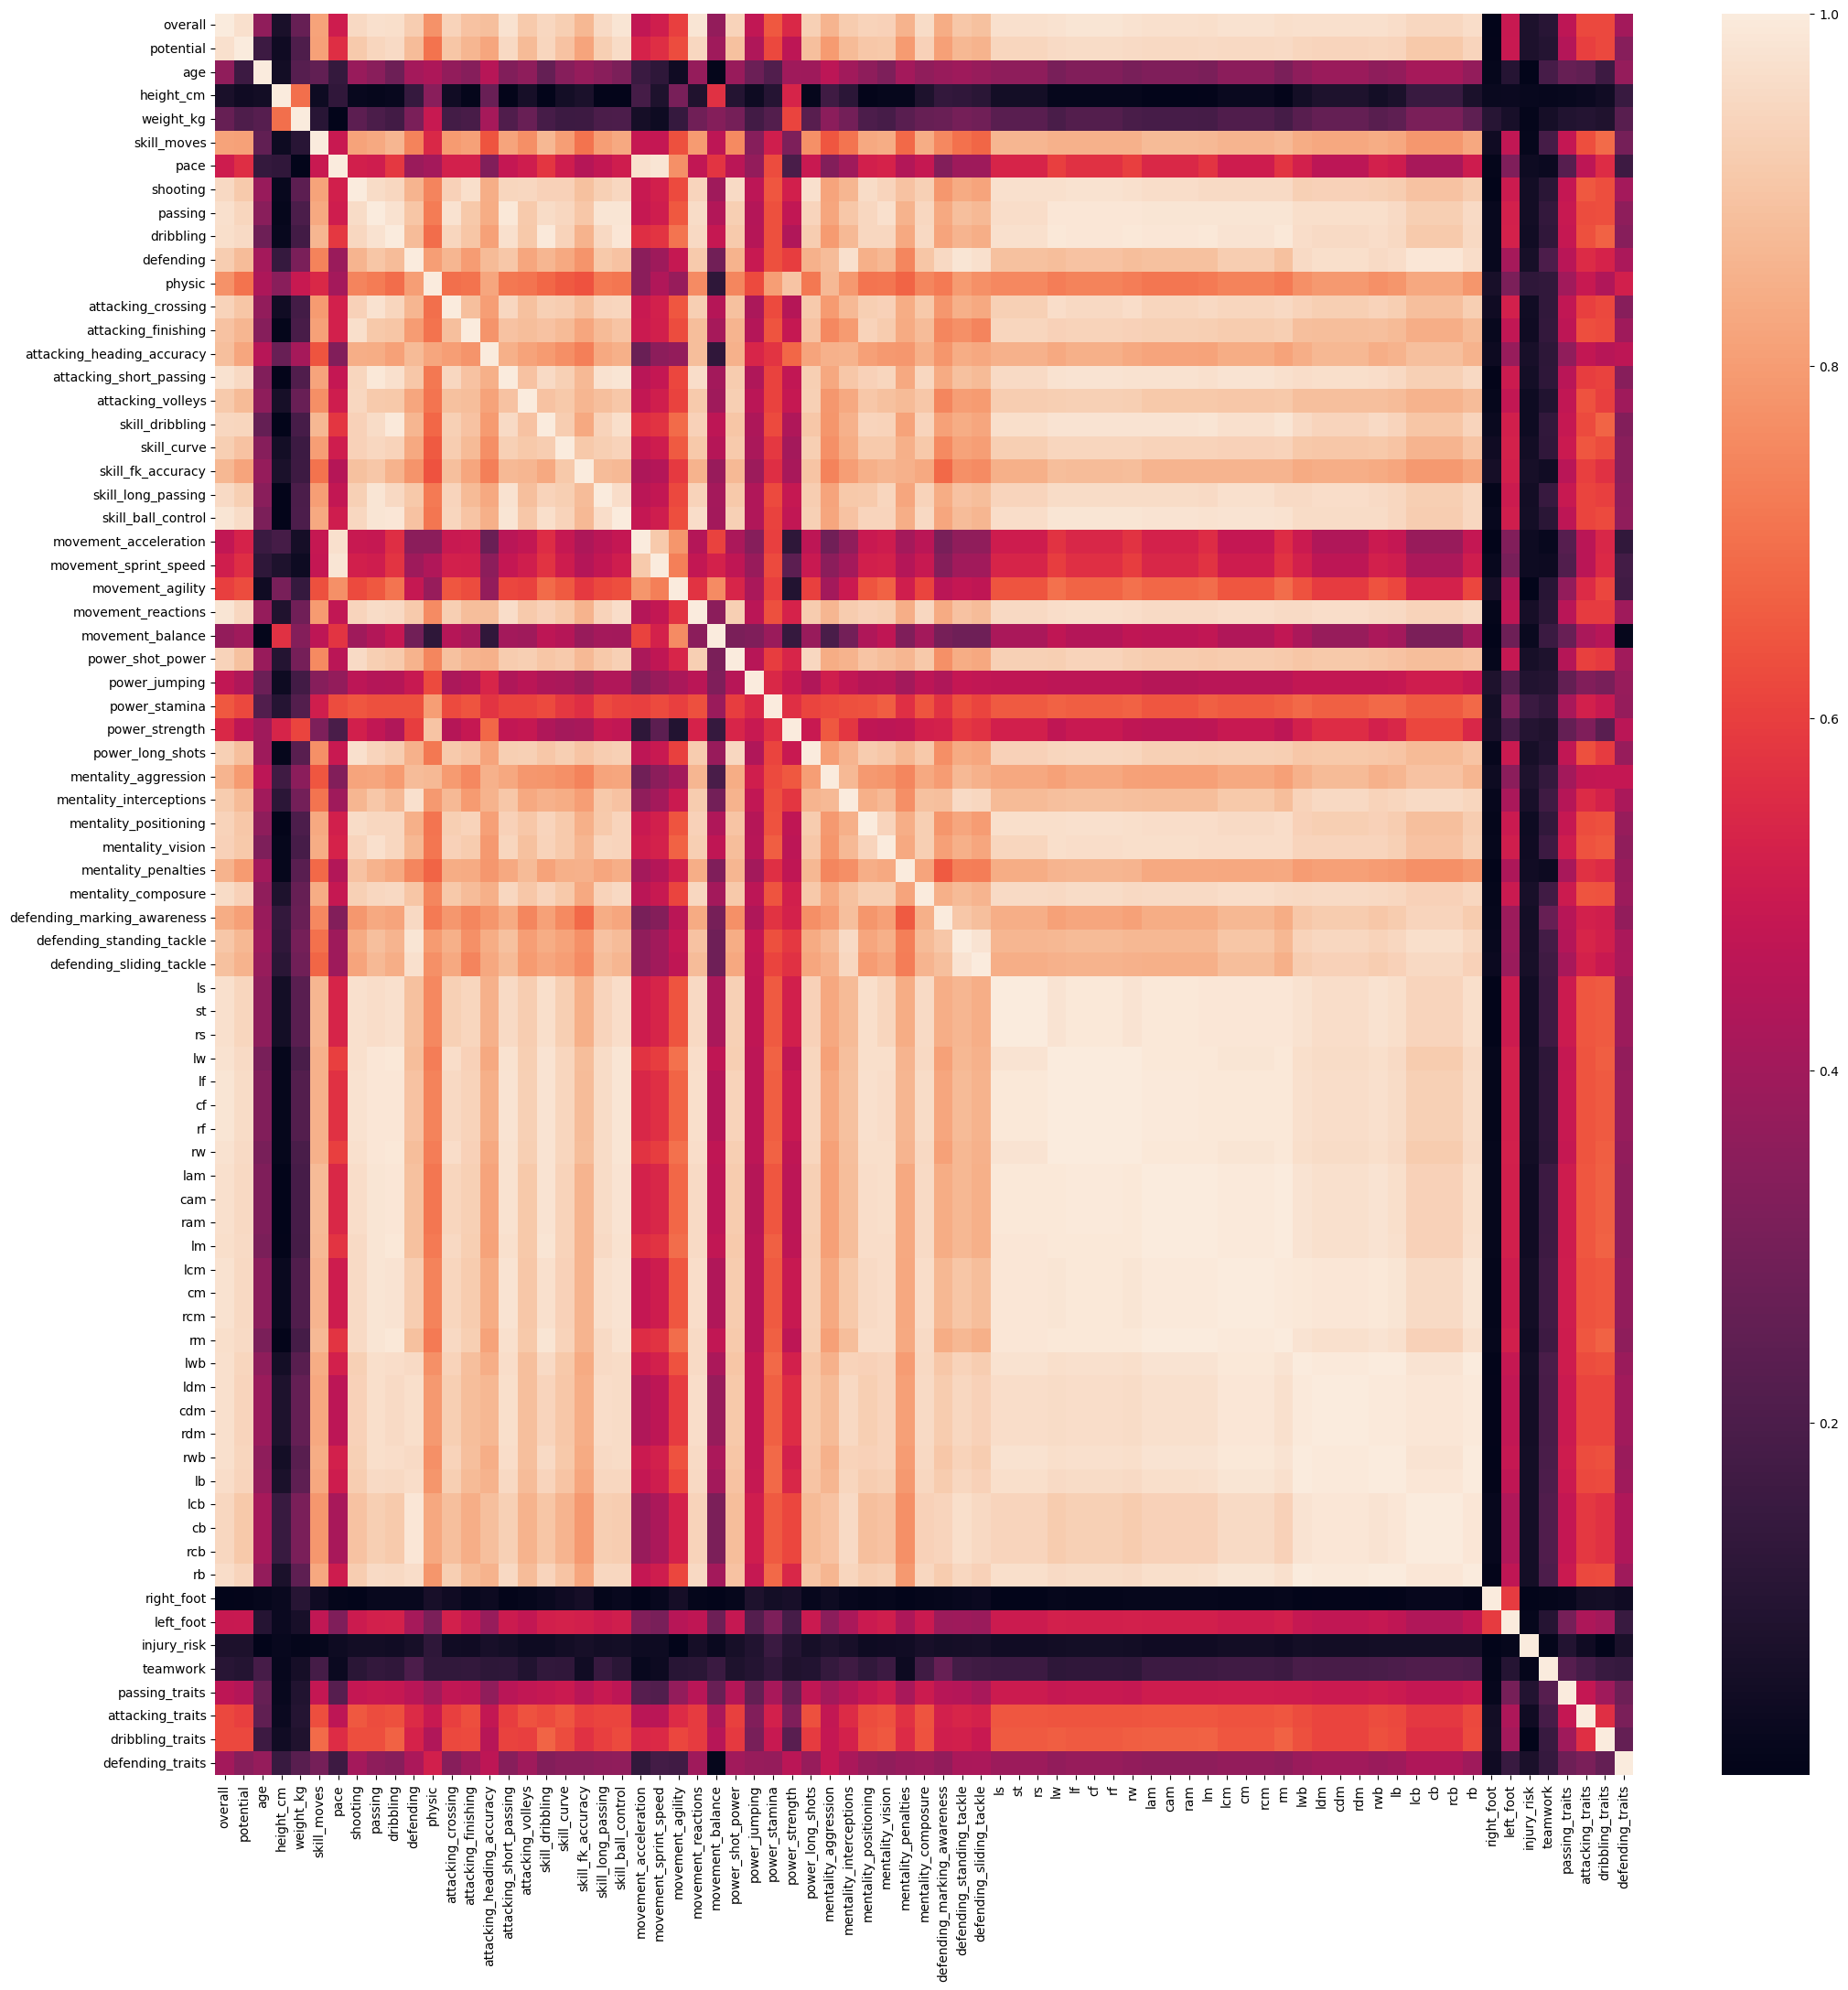

In [29]:
plt.figure(figsize = (25,25))
ax = sns.heatmap(abs(X_.corr()))

Define the function to train the models

In [30]:
def train_test(classifier, X_data, y_data, i = 0, confusion_m=False):
    
    scaler = StandardScaler()
    #scaler = MinMaxScaler()
    
    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42 + i)

    scores_df_test = pd.DataFrame(index=['accuracy', 'recall', 'precision', 'f1'])
    #scores_df_test = pd.DataFrame(index=['recall', 'precision', 'f1'])
    scores_df_train = pd.DataFrame(index=['accuracy', 'recall', 'precision', 'f1'])
    #scores_df_train = pd.DataFrame(index=['recall', 'precision', 'f1'])
    coefs_df = pd.DataFrame(index=list(X_data.columns))
    
    n_split = 1

    for train_index, test_index in skf.split(X_data, y_data):
        
        if str(classifier).split('(')[0] == 'LogisticRegression':
            X_train, X_test = scaler.fit_transform(X_data.iloc[train_index]), scaler.transform(X_data.iloc[test_index])
        else: 
            X_train, X_test = X_data.iloc[train_index], X_data.iloc[test_index]
        
        y_train, y_test = y_data.iloc[train_index], y_data.iloc[test_index]
            
        classifier.fit(X_train, y_train)
                                                     
        train_predictions = classifier.predict(X_train)
        test_predictions = classifier.predict(X_test)
                                                                                                  
        coefs = pd.DataFrame()
        coefs['names'] = list(X_data.columns)  
            
        if str(classifier).split('(')[0] != 'GaussianNB':
            if str(classifier).split('(')[0] == 'LogisticRegression':
                coefs_df[n_split] =  classifier.coef_.tolist()[0]
            else:
                coefs_df[n_split]  = classifier.feature_importances_.tolist()                                        
            coefs_df['mean'] = coefs_df.mean(axis=1)

        scores_df_test[n_split] = [accuracy_score(test_predictions, y_test), recall_score(test_predictions, y_test), 
                                   precision_score(test_predictions, y_test), f1_score(test_predictions, y_test)] 
        
        scores_df_train[n_split] = [accuracy_score(train_predictions, y_train), recall_score(train_predictions, y_train), 
                                    precision_score(train_predictions, y_train), f1_score(train_predictions, y_train)] 
        
        if confusion_m:
            cm = confusion_matrix(y_test, test_predictions)
            disp = ConfusionMatrixDisplay(confusion_matrix=cm,
            display_labels=clf.classes_)
            disp.plot();
        
        n_split +=1
        
    scores_df_test['mean_test'] = scores_df_test.mean(axis=1)
    scores_df_train['mean_train'] = scores_df_train.mean(axis=1)
    
    
    #display(scores_df_test, scores_df_train)
    
    return scores_df_test, scores_df_train, coefs_df    

In [31]:
#The labels are quite balanced so oversampling is not required
print(len(y[y==1]))
print(len(y[y==0]))

761
729


**Data cleaning completed for supervised learning**

3 models are used for the dataset
1) Logistic regression
2) Gradient Boosting
3) GaussianNB

Part 1 Feature ablation: 
- Use all features in 3 models (X_)

In [32]:
#1_test_alldata Primary test set results for Logistic untuned Model
display(train_test(LogisticRegression(random_state=42, max_iter=1000), X_, y)[0].iloc[:,-1:])

#1_train_alldata Primary train set results for Logistic untuned Model
display(train_test(LogisticRegression(random_state=42, max_iter=1000), X_, y)[1].iloc[:,-1:])

,mean_test
accuracy,0.655034
recall,0.669429
precision,0.643968
f1,0.655942


,mean_train
accuracy,0.686204
recall,0.701828
precision,0.670463
f1,0.685765


In [33]:
#2_test_alldata Primary test set results for GB untuned Model
display(train_test(GradientBoostingClassifier(random_state=42), X_, y)[0].iloc[:,-1:])

#2_train_alldata Primary train set results for GB untuned Model
#There is a lot of overfitting
display(train_test(GradientBoostingClassifier(random_state=42), X_, y)[1].iloc[:,-1:])

,mean_test
accuracy,0.652349
recall,0.684948
precision,0.595232
f1,0.636073


,mean_train
accuracy,0.894780
recall,0.938442
precision,0.849759
f1,0.891876


In [34]:
#3_test_alldata Primary test set results for GaussianNB untuned Model
display(train_test(GaussianNB(), X_, y)[0].iloc[:,-1:])

#3_train_alldata Primary train set results for GaussianNB untuned Model
display(train_test(GaussianNB(), X_, y)[1].iloc[:,-1:])

,mean_test
accuracy,0.608725
recall,0.648384
precision,0.517755
f1,0.574995


,mean_train
accuracy,0.612155
recall,0.650118
precision,0.520954
f1,0.578374


Part 1 Feature ablation (continued):

- Drop the position rating features (X_2)

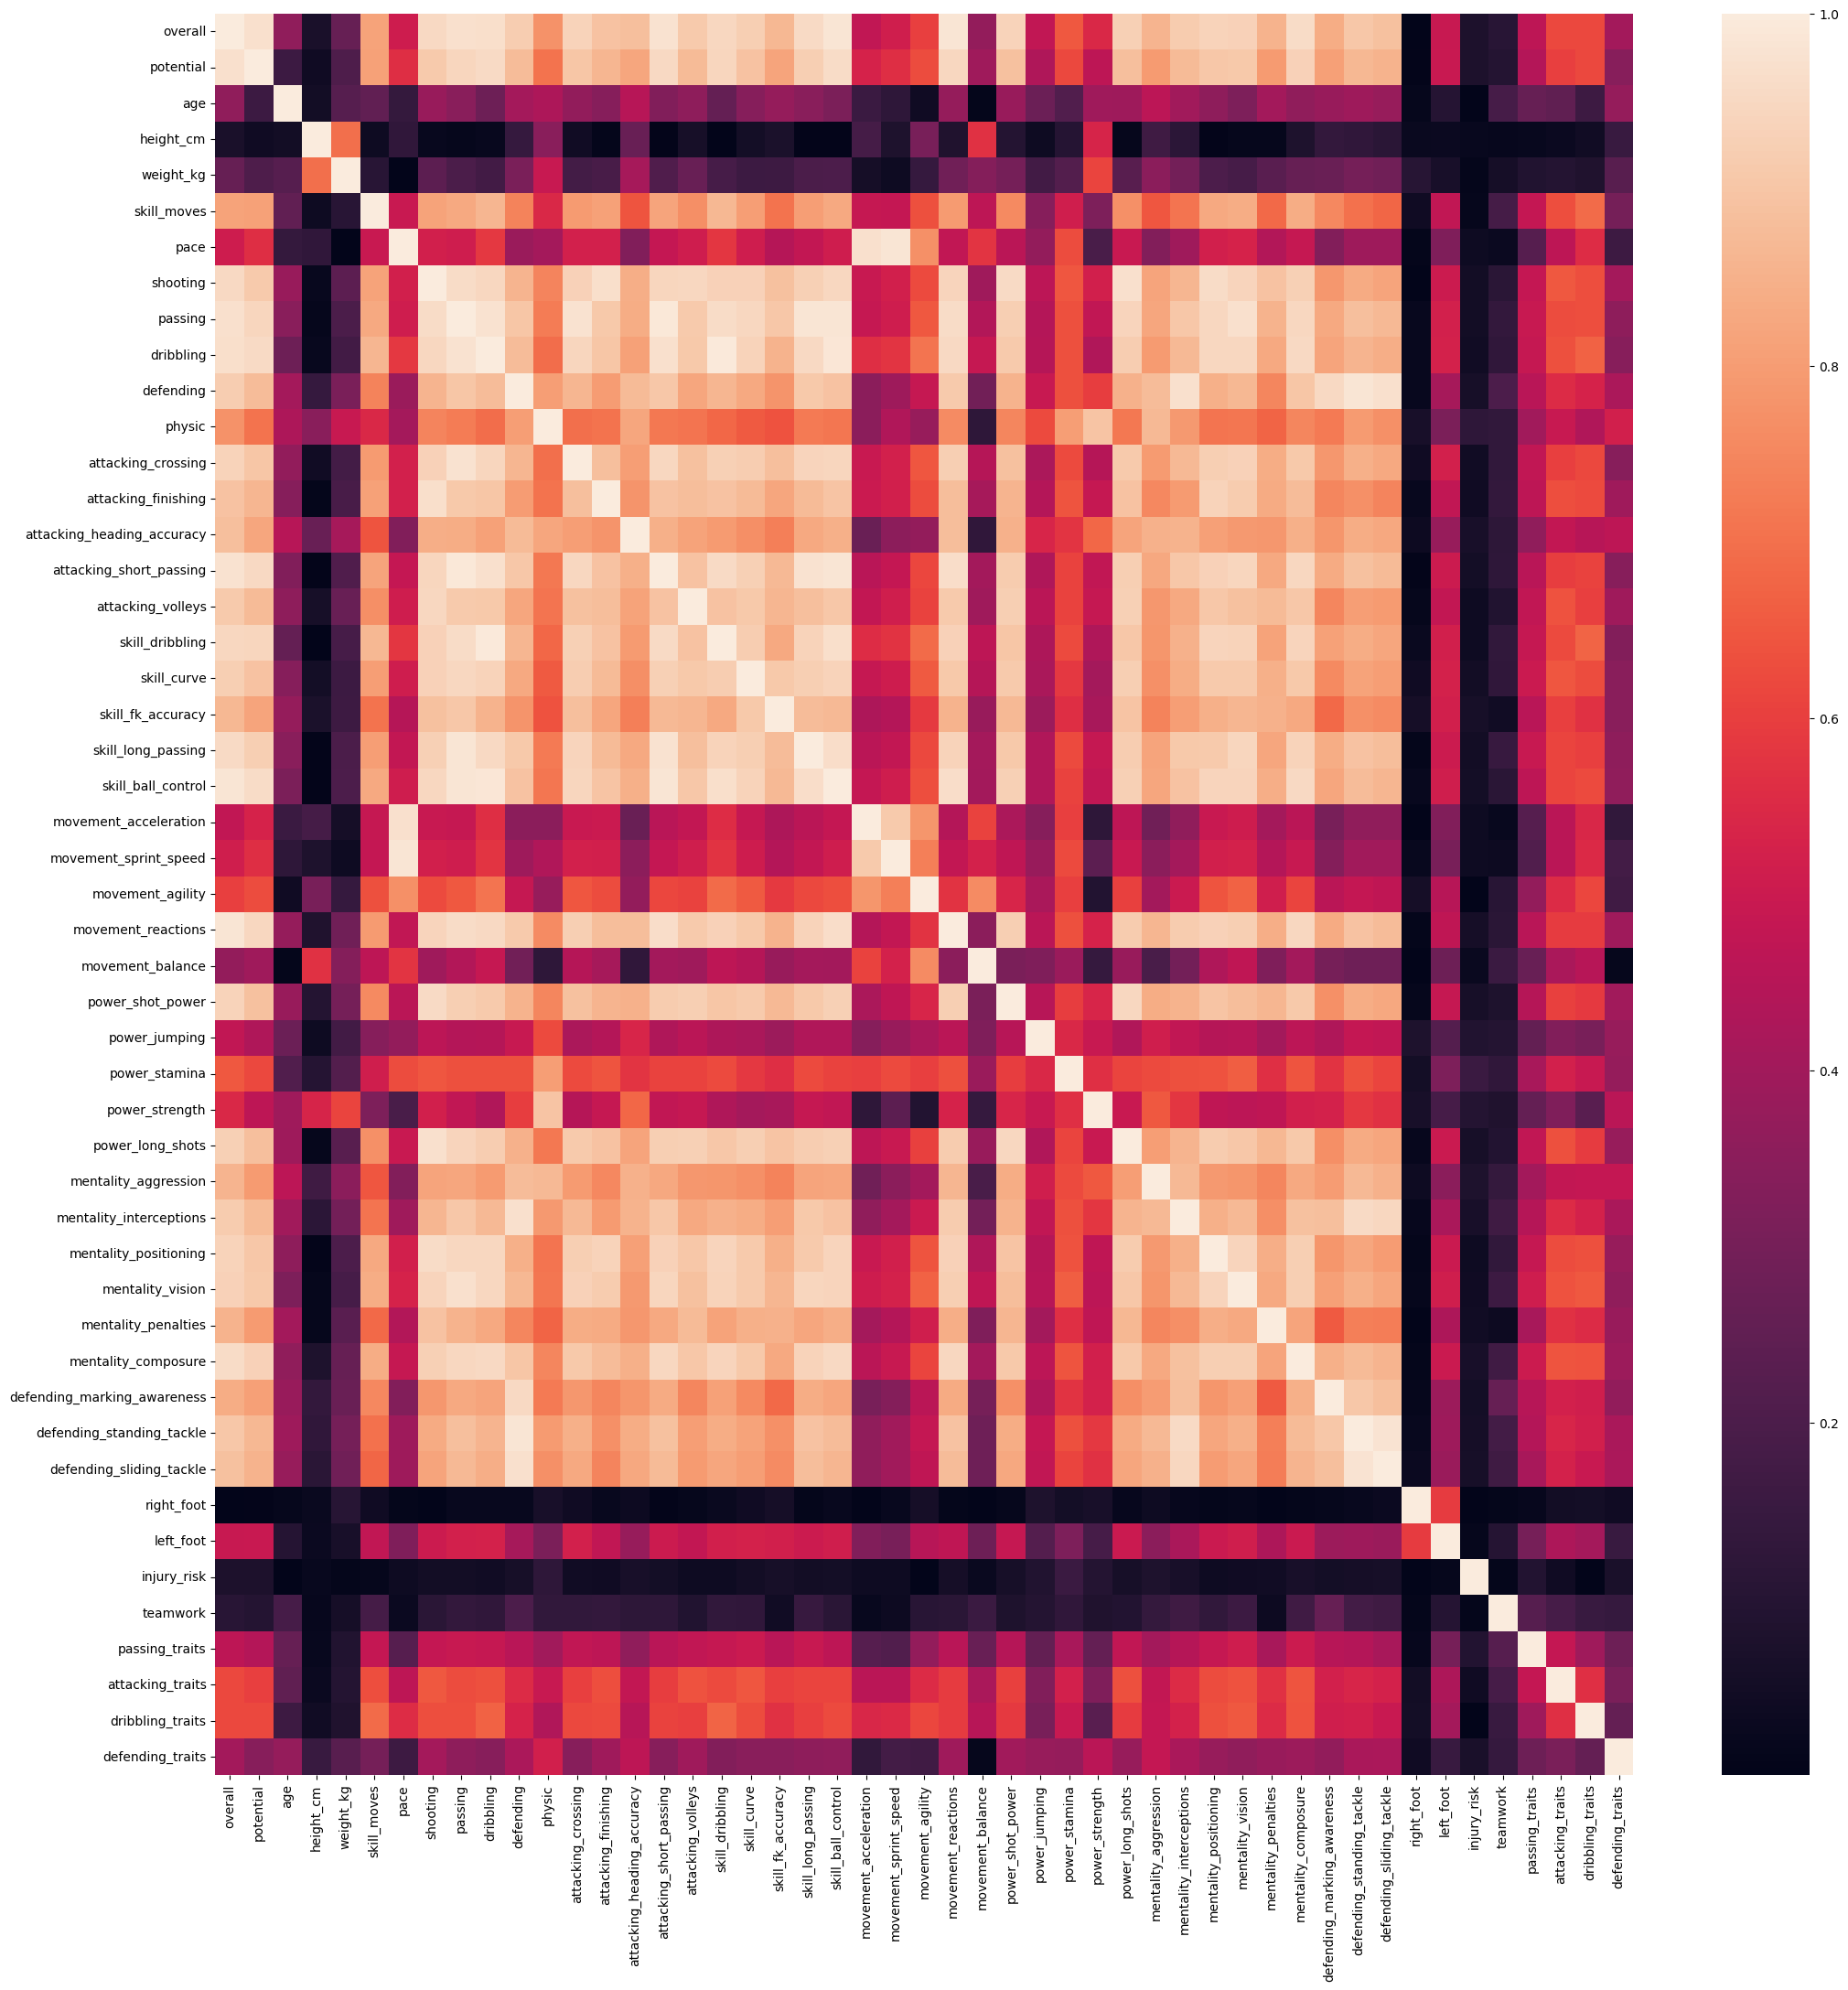

In [35]:
#There are many highly correlated features that can be dropped such as the features related to player position
correlated_drop = ['ls','st', 'rs', 'lw', 'lf', 'cf', 'rf', 'rw', 'lam', 'cam','ram', 'lm', 'lcm', 'cm', 'rcm', 'rm',
                   'lwb', 'ldm', 'cdm', 'rdm', 'rwb', 'lb', 'lcb', 'cb', 'rcb', 'rb']
X_2 = X_.drop(columns = correlated_drop)
plt.figure(figsize = (25,25))
ax = sns.heatmap(abs(X_2.corr()))

In [36]:
#1_test_dropped_pos Primary test set results for Logistic untuned Model
display(train_test(LogisticRegression(random_state=42, max_iter=1000), X_2, y)[0].iloc[:,-1:])

#1_train_dropped_pos Primary train set results for Logistic untuned Model
display(train_test(LogisticRegression(random_state=42, max_iter=1000), X_2, y)[1].iloc[:,-1:])

,mean_test
accuracy,0.658389
recall,0.672468
precision,0.649231
f1,0.660192


,mean_train
accuracy,0.683743
recall,0.698796
precision,0.669295
f1,0.683718


In [37]:
#2_test_dropped_pos Primary test set results for GB untuned Model
display(train_test(GradientBoostingClassifier(random_state=42), X_2, y)[0].iloc[:,-1:])

#2_train_dropped_pos Primary train set results for GB untuned Model
#There is a lot of overfitting
display(train_test(GradientBoostingClassifier(random_state=42), X_2, y)[1].iloc[:,-1:])

,mean_test
accuracy,0.646980
recall,0.683866
precision,0.574231
f1,0.623525


,mean_train
accuracy,0.892841
recall,0.940316
precision,0.843773
f1,0.889416


In [38]:
#3_test_dropped_pos Primary test set results for GaussianNB untuned Model
display(train_test(GaussianNB(), X_2, y)[0].iloc[:,-1:])

#3_train_dropped_pos Primary train set results for GaussianNB untuned Model
display(train_test(GaussianNB(), X_2, y)[1].iloc[:,-1:])

,mean_test
accuracy,0.610067
recall,0.646716
precision,0.525666
f1,0.579154


,mean_train
accuracy,0.613423
recall,0.649514
precision,0.527962
f1,0.582442


Part 1 Feature ablation (continued):

- Drop the position rating features, also drop the highly correlated features (X_3)

In [39]:
highly_correlated = X_2.corr()[(abs(X_2.corr()) > 0.8) & (abs(X_2.corr()) < 1)].count()[
X_2.corr()[(abs(X_2.corr()) > 0.8) & (abs(X_2.corr()) < 1)].count()> 5].sort_values(ascending=False)
highly_correlated

overall                        28
mentality_composure            28
skill_ball_control             28
skill_long_passing             28
attacking_short_passing        28
passing                        28
dribbling                      27
shooting                       27
movement_reactions             27
mentality_vision               26
skill_dribbling                26
potential                      26
power_shot_power               26
power_long_shots               26
defending                      25
attacking_crossing             25
mentality_interceptions        25
skill_curve                    25
mentality_positioning          25
attacking_volleys              24
defending_standing_tackle      24
defending_sliding_tackle       22
attacking_heading_accuracy     21
attacking_finishing            21
skill_fk_accuracy              21
mentality_penalties            19
mentality_aggression           16
defending_marking_awareness    15
skill_moves                    14
dtype: int64

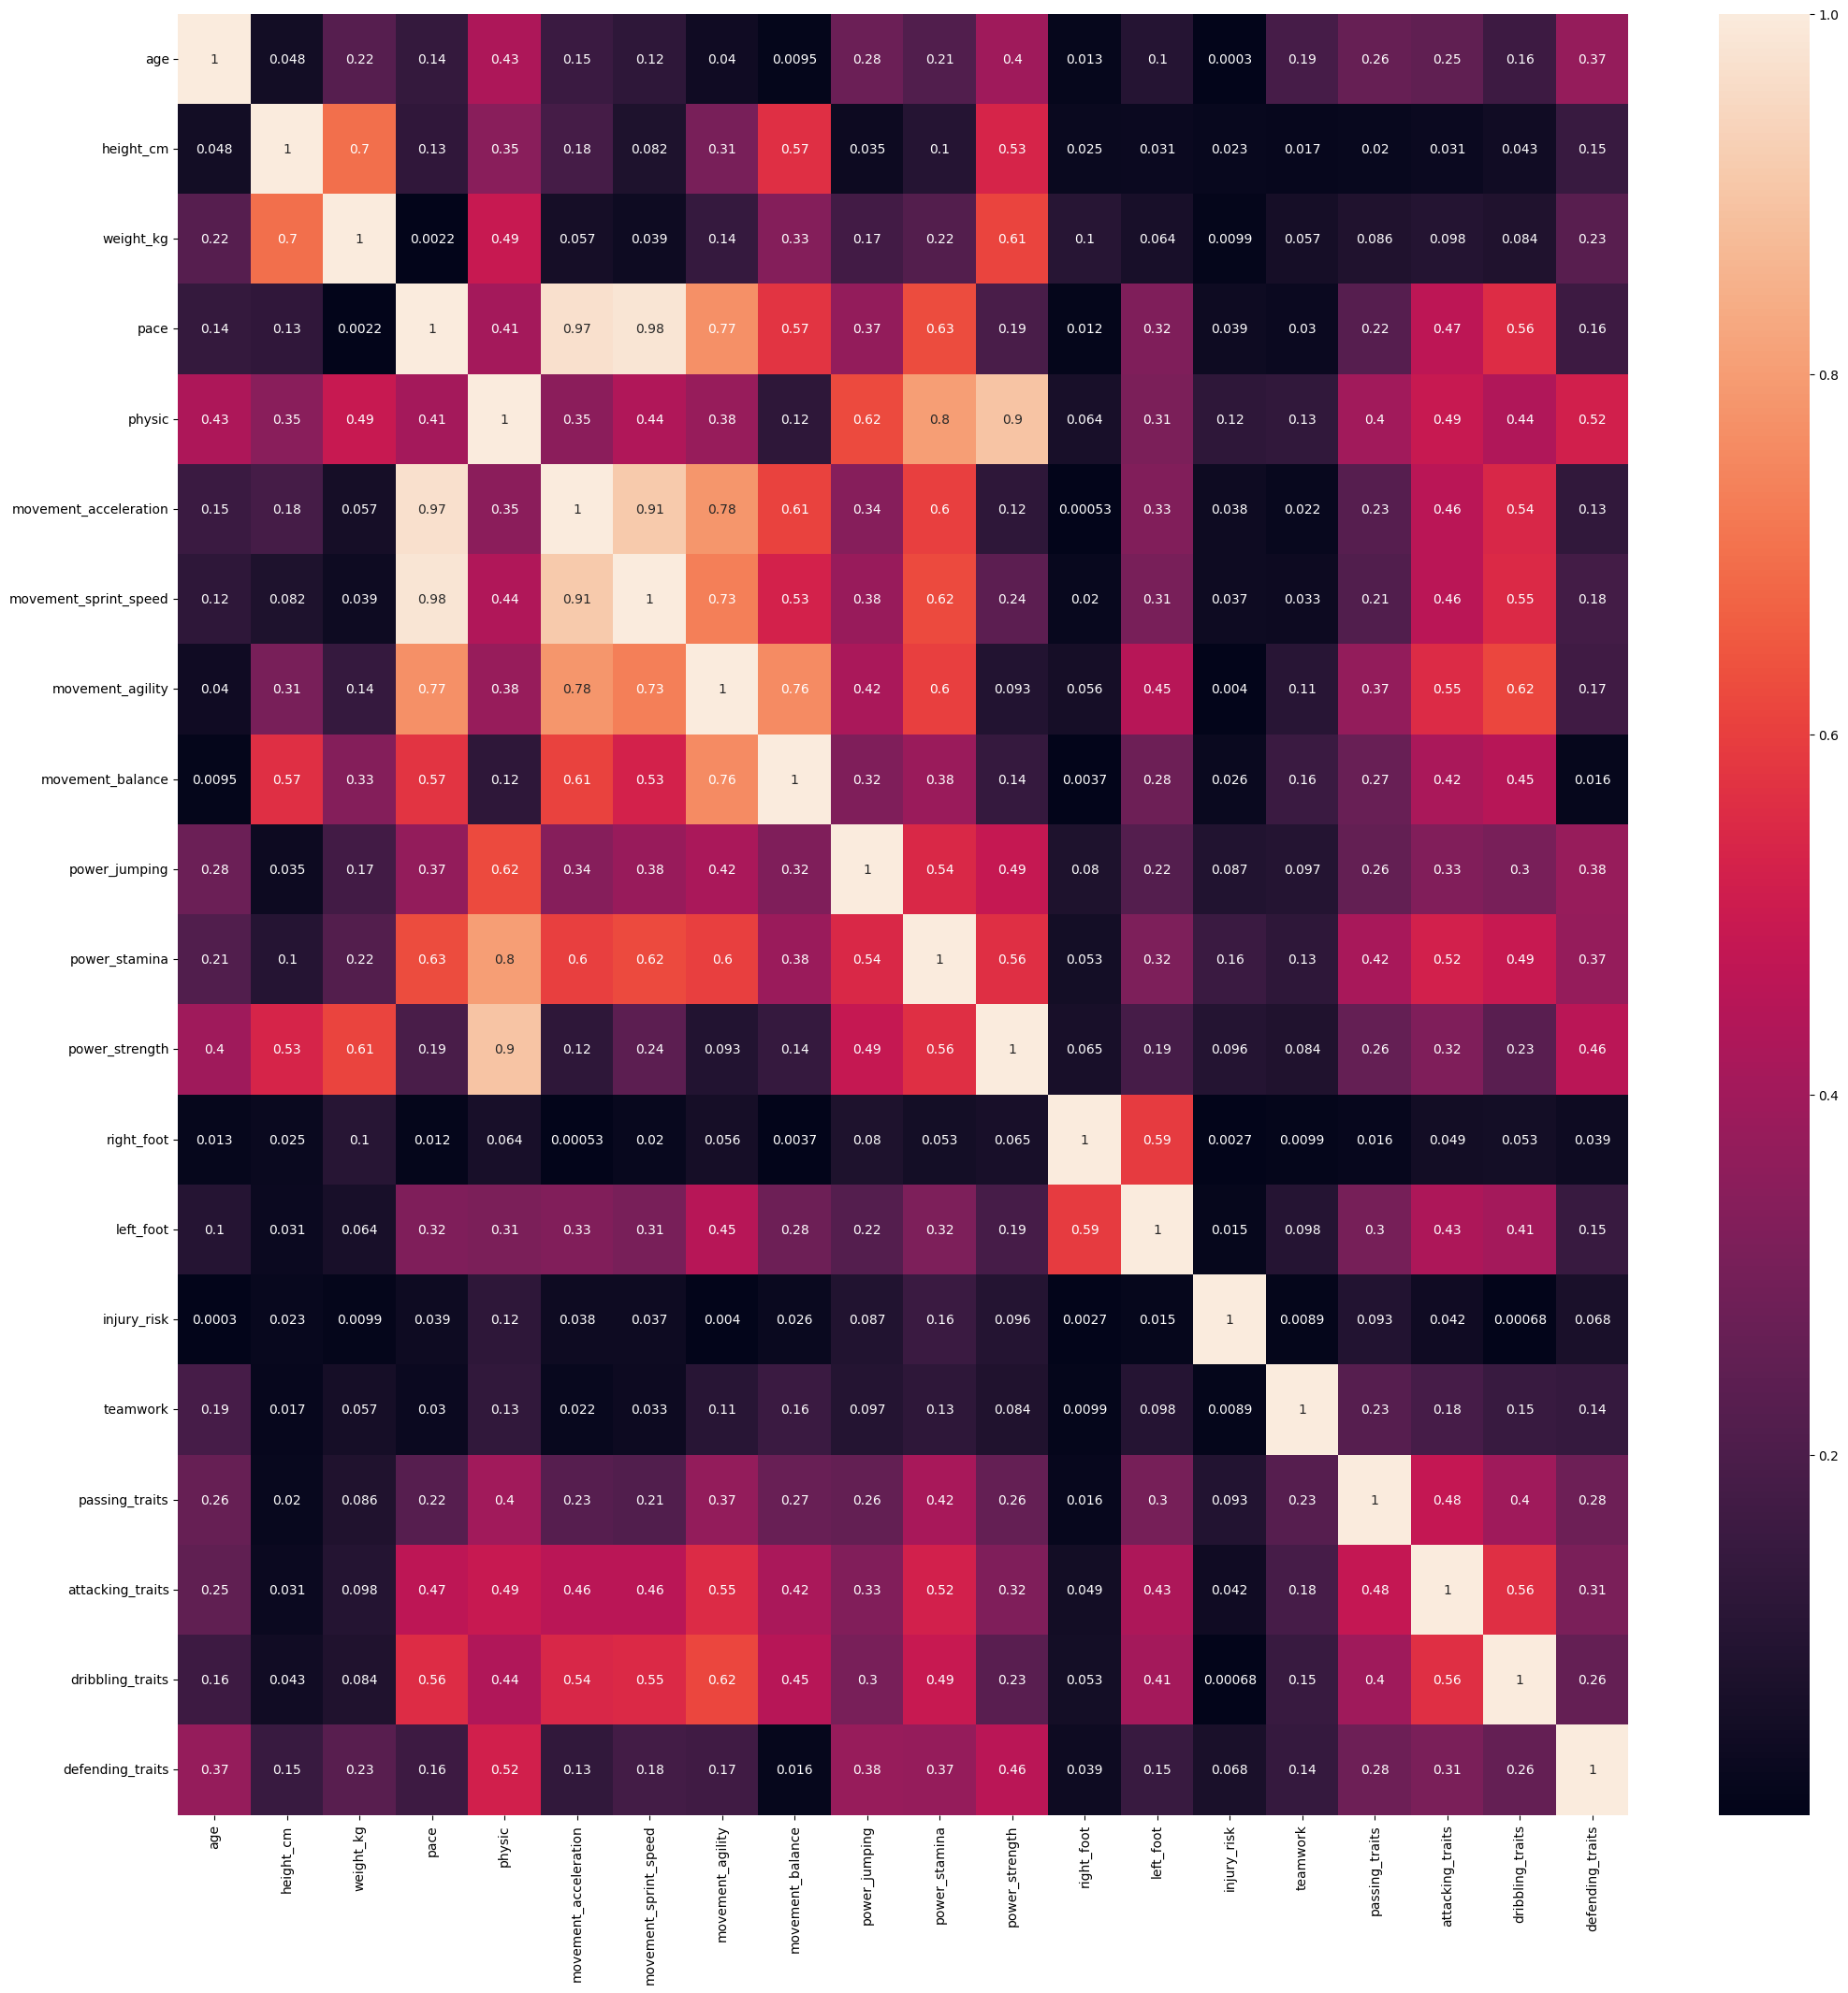

In [40]:
X_3 = X_2.drop(columns = highly_correlated.index)
plt.figure(figsize = (25,25))
ax = sns.heatmap(abs(X_3.corr()), annot=True)

In [41]:
#1_test_dropped_pos_correlated Primary test set results for Logistic untuned Model
display(train_test(LogisticRegression(random_state=42, max_iter=1000), X_3, y)[0].iloc[:,-1:])

#1_train_dropped_pos_correlated Primary train set results for Logistic untuned Model
display(train_test(LogisticRegression(random_state=42, max_iter=1000), X_3, y)[1].iloc[:,-1:])

,mean_test
accuracy,0.646980
recall,0.662010
precision,0.633373
f1,0.646969


,mean_train
accuracy,0.655183
recall,0.668960
precision,0.643159
f1,0.655797


In [42]:
#2_test_dropped_pos_correlated Primary test set results for GB untuned Model
display(train_test(GradientBoostingClassifier(random_state=42), X_3, y)[0].iloc[:,-1:])

#2_train_dropped_pos_correlated Primary train set results for GB untuned Model
#There is a lot of overfitting
display(train_test(GradientBoostingClassifier(random_state=42), X_3, y)[1].iloc[:,-1:])

,mean_test
accuracy,0.630872
recall,0.659439
precision,0.573018
f1,0.611734


,mean_train
accuracy,0.835869
recall,0.885354
precision,0.779677
f1,0.829105


In [43]:
#3_test_dropped_pos_correlated Primary test set results for GaussianNB untuned Model
display(train_test(GaussianNB(), X_3, y)[0].iloc[:,-1:])

#3_train_dropped_pos_correlated Primary train set results for GaussianNB untuned Model
display(train_test(GaussianNB(), X_3, y)[1].iloc[:,-1:])

,mean_test
accuracy,0.642953
recall,0.698770
precision,0.532280
f1,0.603464


,mean_train
accuracy,0.640492
recall,0.695122
precision,0.527523
f1,0.599822


Part 1 Feature ablation (continued):

Drop the position rating features, also drop the highly correlated features, plus ['movement_acceleration', 'movement_sprint_speed', 'movement_agility','attacking_heading_accuracy', 'power_stamina', 'power_strength','movement_balance'] (X_4)

In [44]:
X_3.corr()[(abs(X_3.corr()) > 0.8) & (abs(X_2.corr()) < 1)].count()[
X_3.corr()[(abs(X_3.corr()) > 0.8) & (abs(X_2.corr()) < 1)].count()>= 1].sort_values(ascending=False)

pace                     2
physic                   2
movement_acceleration    2
movement_sprint_speed    2
power_stamina            1
power_strength           1
dtype: int64

In [45]:
X_3

,age,height_cm,weight_kg,pace,physic,movement_acceleration,movement_sprint_speed,movement_agility,movement_balance,power_jumping,power_stamina,power_strength,right_foot,left_foot,injury_risk,teamwork,passing_traits,attacking_traits,dribbling_traits,defending_traits
0,26.40,180.40,76.60,73.60,72.45,73.40,73.85,76.25,74.25,70.15,75.70,71.55,4.45,3.95,0.20,0.05,0.40,0.40,0.25,0.25
1,25.60,185.00,78.30,72.65,73.70,71.45,73.40,67.70,66.20,68.70,74.85,74.50,4.45,4.05,0.00,0.10,0.15,0.30,0.15,0.25
2,25.70,182.15,76.25,69.55,69.60,69.50,69.60,70.35,67.85,67.15,73.95,67.65,4.30,4.00,-0.10,0.20,0.10,0.35,0.40,0.00
3,24.15,183.30,78.80,73.00,69.55,71.70,74.10,67.90,65.65,70.35,71.70,69.05,4.75,3.70,0.05,0.05,0.05,0.25,0.25,0.15
4,26.75,182.35,78.25,71.95,71.05,72.15,71.90,68.30,66.05,70.95,72.50,71.90,4.40,3.80,0.05,0.10,0.10,0.20,0.10,0.10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1718,27.50,181.70,75.00,65.55,71.85,65.45,65.45,67.30,64.70,67.55,71.60,73.85,4.25,3.55,-0.05,0.15,0.15,0.25,0.15,0.10
1720,27.00,180.90,74.00,64.80,64.25,65.50,64.45,66.30,63.45,67.35,67.45,64.80,4.50,3.60,-0.05,0.25,0.10,0.05,0.25,0.10
1721,24.50,179.90,73.20,66.85,67.50,67.15,66.85,67.35,67.15,64.35,67.15,68.95,4.30,3.75,0.05,0.10,0.05,0.30,0.10,0.10
1722,24.75,180.65,72.60,71.70,66.55,72.70,70.80,70.70,68.45,66.95,71.45,65.70,4.55,3.55,0.15,0.10,0.20,0.30,0.35,0.10


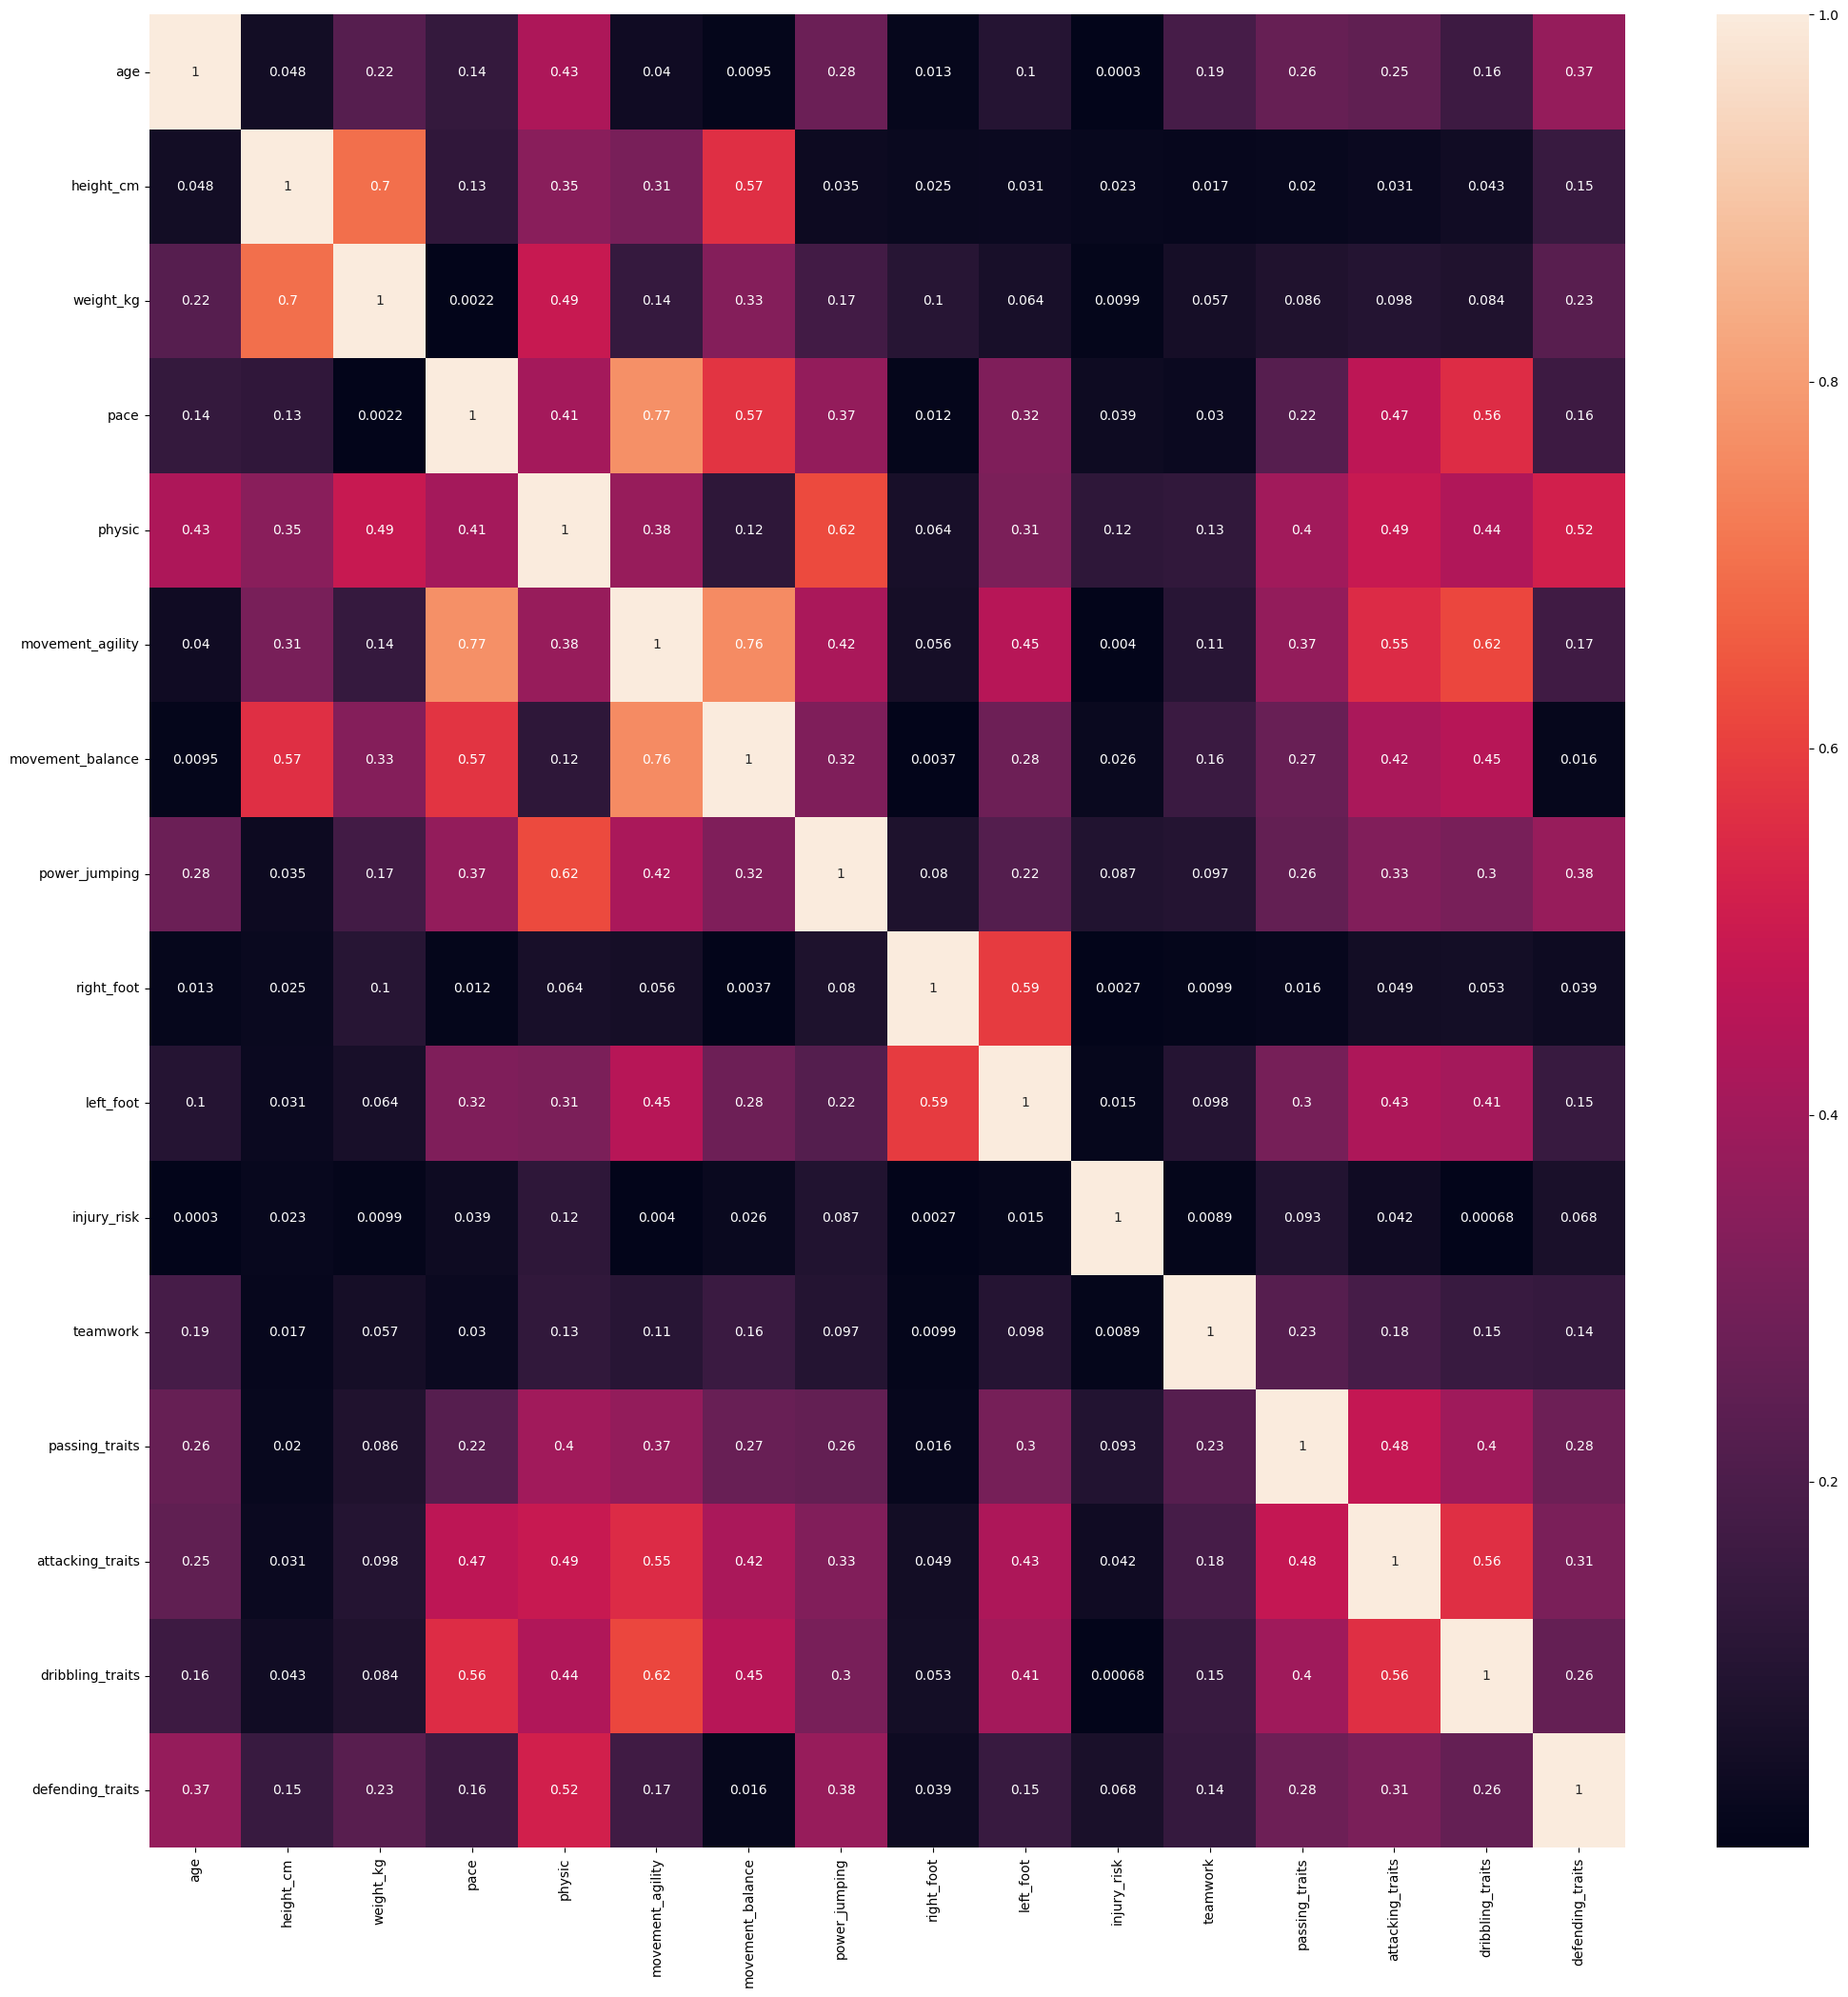

In [46]:
X_4 = X_3.drop(columns = ['movement_acceleration', 'movement_sprint_speed', 'power_stamina', 'power_strength'])
plt.figure(figsize = (25,25))
ax = sns.heatmap(abs(X_4.corr()), annot=True)

In [47]:
X_4.columns

Index(['age', 'height_cm', 'weight_kg', 'pace', 'physic', 'movement_agility',
       'movement_balance', 'power_jumping', 'right_foot', 'left_foot',
       'injury_risk', 'teamwork', 'passing_traits', 'attacking_traits',
       'dribbling_traits', 'defending_traits'],
      dtype='object')

In [48]:
#1_test_dropped_pos_correlated_2 Primary test set results for Logistic untuned Model
display(train_test(LogisticRegression(random_state=42, max_iter=1000), X_4, y)[0].iloc[:,-1:])

#1_train_dropped_pos_correlated_2 Primary train set results for Logistic untuned Model
display(train_test(LogisticRegression(random_state=42, max_iter=1000), X_4, y)[1].iloc[:,-1:])

,mean_test
accuracy,0.642953
recall,0.654371
precision,0.638653
f1,0.645695


,mean_train
accuracy,0.655928
recall,0.668796
precision,0.646518
f1,0.657461


In [49]:
#2_test_dropped_pos_correlated_2 Primary test set results for GB untuned Model
display(train_test(GradientBoostingClassifier(random_state=42), X_4, y)[0].iloc[:,-1:])

#2_train_dropped_pos_correlated_2 Primary train set results for GB untuned Model
#There is a lot of overfitting, but slightly reduced
display(train_test(GradientBoostingClassifier(random_state=42), X_4, y)[1].iloc[:,-1:])

,mean_test
accuracy,0.635570
recall,0.664991
precision,0.575564
f1,0.616316


,mean_train
accuracy,0.821999
recall,0.877678
precision,0.757046
f1,0.812872


In [50]:
#3_test_dropped_pos_correlated_2 Primary test set results for GaussianNB untuned Model
display(train_test(GaussianNB(), X_4, y)[0].iloc[:,-1:])

#3_train_dropped_pos_correlated_2 Primary train set results for GaussianNB untuned Model
display(train_test(GaussianNB(), X_4, y)[1].iloc[:,-1:])

,mean_test
accuracy,0.636242
recall,0.682752
precision,0.536193
f1,0.600103


,mean_train
accuracy,0.639821
recall,0.689183
precision,0.537015
f1,0.603629


**End of Part 1**

Part 2 Tradeoff analysis:

- Speed vs accuracy (compare X_ and X_4) on training data

In [51]:
#Logistic regression

start_time = time.time()

#1_train_alldata Primary train set results for Logistic untuned Model
display(train_test(LogisticRegression(random_state=42, max_iter=1000), X_, y)[1].iloc[:,-1:])

print("--- %s seconds ---" % (time.time() - start_time))

,mean_train
accuracy,0.686204
recall,0.701828
precision,0.670463
f1,0.685765


--- 0.5133330821990967 seconds ---


In [52]:
start_time = time.time()

#1_train_dropped_pos_correlated_2 Primary train set results for Logistic untuned Model
display(train_test(LogisticRegression(random_state=42, max_iter=1000), X_4, y)[1].iloc[:,-1:])

print("--- %s seconds ---" % (time.time() - start_time))

,mean_train
accuracy,0.655928
recall,0.668796
precision,0.646518
f1,0.657461


--- 0.12235808372497559 seconds ---


In [53]:
#Gradient boosting

start_time = time.time()

#2_train_alldata Primary train set results for GB untuned Model
#There is a lot of overfitting
display(train_test(GradientBoostingClassifier(random_state=42), X_, y)[1].iloc[:,-1:])

print("--- %s seconds ---" % (time.time() - start_time))

,mean_train
accuracy,0.894780
recall,0.938442
precision,0.849759
f1,0.891876


--- 13.834664821624756 seconds ---


In [54]:
start_time = time.time()

#2_train_dropped_pos_correlated_2 Primary train set results for GB untuned Model
#There is a lot of overfitting, but slightly reduced
display(train_test(GradientBoostingClassifier(random_state=42), X_4, y)[1].iloc[:,-1:])

print("--- %s seconds ---" % (time.time() - start_time))

,mean_train
accuracy,0.821999
recall,0.877678
precision,0.757046
f1,0.812872


--- 2.5063490867614746 seconds ---


In [55]:
#GaussianNB

start_time = time.time()

#3_train_alldata Primary train set results for GaussianNB untuned Model
display(train_test(GaussianNB(), X_, y)[1].iloc[:,-1:])

print("--- %s seconds ---" % (time.time() - start_time))

,mean_train
accuracy,0.612155
recall,0.650118
precision,0.520954
f1,0.578374


--- 0.08188414573669434 seconds ---


In [56]:
start_time = time.time()

#3_train_dropped_pos_correlated_2 Primary train set results for GaussianNB untuned Model
display(train_test(GaussianNB(), X_4, y)[1].iloc[:,-1:])

print("--- %s seconds ---" % (time.time() - start_time))

,mean_train
accuracy,0.639821
recall,0.689183
precision,0.537015
f1,0.603629


--- 0.06926989555358887 seconds ---


Part 2 Tradeoff analysis (continued):

- Amount of data vs accuracy (we drop all teams that are not league_leve = 1), compare the result using training data in X_4 (after dropping all unnecessary features)

In [57]:
#drop teams that are not in league 1, then drop the features with the same criteria like when we include all league levels
merged_league_1 = merged[merged.league_level == 1].reset_index(drop=True)
merged_league_1_20_players = merged_league_1[merged_league_1.club_season.isin(keep_clubs)]
y1 = merged_league_1_20_players.Rank.apply(lambda x: 1 if x <=10 else 0)
print(len(y1[y1 == 1]))
print(len(y1[y1 == 0]))

561
460


In [58]:
X1_ = merged_league_1_20_players.drop(columns=drop_columns)
correlated_drop = ['ls','st', 'rs', 'lw', 'lf', 'cf', 'rf', 'rw', 'lam', 'cam','ram', 'lm', 'lcm', 'cm', 'rcm', 'rm',
                   'lwb', 'ldm', 'cdm', 'rdm', 'rwb', 'lb', 'lcb', 'cb', 'rcb', 'rb']
X1_2 = X1_.drop(columns = correlated_drop)
highly_correlated = X1_2.corr()[(abs(X1_2.corr()) > 0.8) & (abs(X1_2.corr()) < 1)].count()[
X1_2.corr()[(abs(X1_2.corr()) > 0.8) & (abs(X1_2.corr()) < 1)].count()> 5].sort_values(ascending=False)
X1_3 = X1_2.drop(columns = highly_correlated.index)

In [59]:
X1_3.corr()[(abs(X1_3.corr()) > 0.8) & (abs(X1_2.corr()) < 1)].count()[
X1_3.corr()[(abs(X1_3.corr()) > 0.8) & (abs(X1_2.corr()) < 1)].count()>= 1].sort_values(ascending=False)

pace                          3
physic                        3
movement_acceleration         3
movement_sprint_speed         2
movement_agility              2
attacking_heading_accuracy    1
power_stamina                 1
power_strength                1
dtype: int64

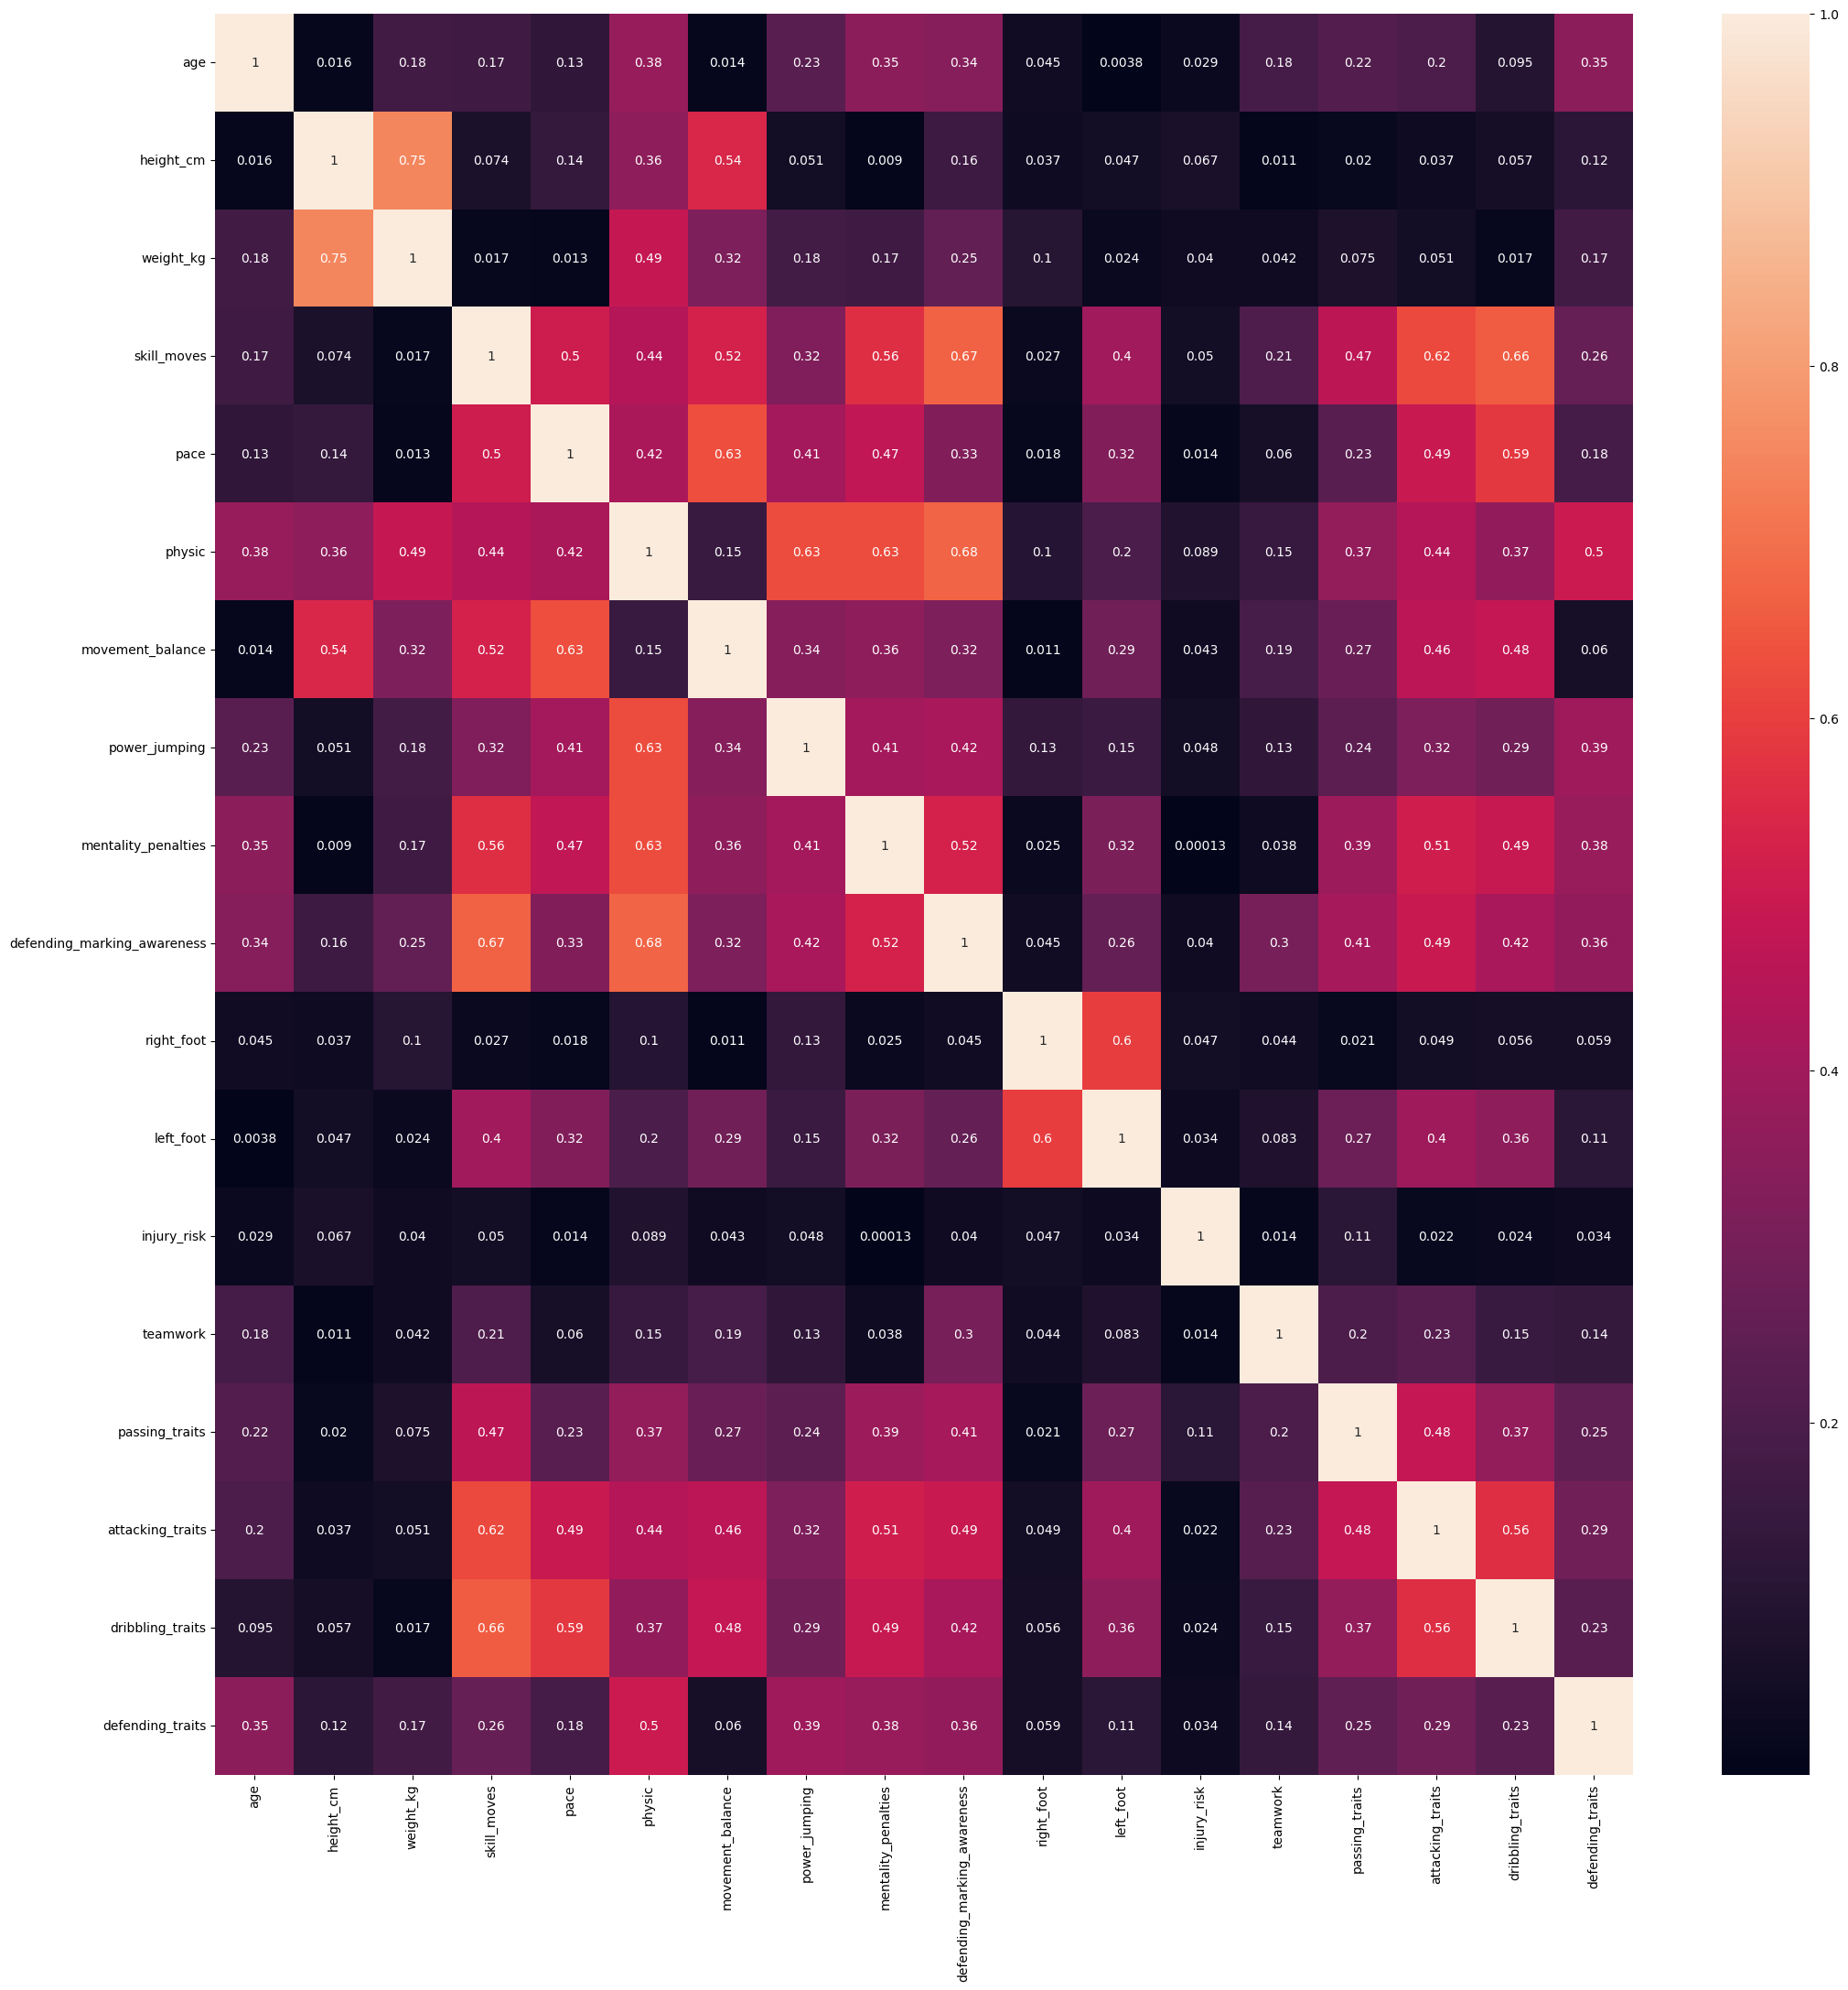

In [60]:
X1_4 = X1_3.drop(columns = ['movement_acceleration', 'movement_sprint_speed', 'movement_agility', 
                            'attacking_heading_accuracy', 'power_stamina', 'power_strength'])
plt.figure(figsize = (25,25))
ax = sns.heatmap(abs(X1_4.corr()), annot=True)

Compare the models trained and tested (all league vs league_level = 1 only)

In [61]:
#Logistric regression, all leagues

#1_test_dropped_pos_correlated_2 Primary test set results for Logistic untuned Model
display(train_test(LogisticRegression(random_state=42, max_iter=1000), X_4, y)[0].iloc[:,-1:])

#1_train_dropped_pos_correlated_2 Primary train set results for Logistic untuned Model
display(train_test(LogisticRegression(random_state=42, max_iter=1000), X_4, y)[1].iloc[:,-1:])

,mean_test
accuracy,0.642953
recall,0.654371
precision,0.638653
f1,0.645695


,mean_train
accuracy,0.655928
recall,0.668796
precision,0.646518
f1,0.657461


In [62]:
#Logistric regression, league_level=1 only

#1_test_dropped_pos_correlated_2 Primary test set results for Logistic untuned Model
display(train_test(LogisticRegression(random_state=42, max_iter=1000), X1_4, y1)[0].iloc[:,-1:])

#1_train_dropped_pos_correlated_2 Primary train set results for Logistic untuned Model
display(train_test(LogisticRegression(random_state=42, max_iter=1000), X1_4, y1)[1].iloc[:,-1:])

,mean_test
accuracy,0.680687
recall,0.707848
precision,0.714850
f1,0.710524


,mean_train
accuracy,0.684731
recall,0.711407
precision,0.717172
f1,0.714275


In [63]:
#Gradient boosting, all leagues

#2_test_dropped_pos_correlated_2 Primary test set results for GB untuned Model
display(train_test(GradientBoostingClassifier(random_state=42), X_4, y)[0].iloc[:,-1:])

#2_train_dropped_pos_correlated_2 Primary train set results for GB untuned Model
#There is a lot of overfitting, but slightly reduced
display(train_test(GradientBoostingClassifier(random_state=42), X_4, y)[1].iloc[:,-1:])

,mean_test
accuracy,0.635570
recall,0.664991
precision,0.575564
f1,0.616316


,mean_train
accuracy,0.821999
recall,0.877678
precision,0.757046
f1,0.812872


In [64]:
#Gradient boosting, league_level=1 only

#2_test_dropped_pos_correlated_2 Primary test set results for GB untuned Model
display(train_test(GradientBoostingClassifier(random_state=42), X1_4, y1)[0].iloc[:,-1:])

#2_train_dropped_pos_correlated_2 Primary train set results for GB untuned Model
#There is a lot of overfitting, but slightly reduced
display(train_test(GradientBoostingClassifier(random_state=42), X1_4, y1)[1].iloc[:,-1:])

,mean_test
accuracy,0.672901
recall,0.719979
precision,0.666823
f1,0.690628


,mean_train
accuracy,0.890957
recall,0.922803
precision,0.874829
f1,0.898109


In [65]:
#GaussianNB, all leagues

#3_test_dropped_pos_correlated_2 Primary test set results for GaussianNB untuned Model
display(train_test(GaussianNB(), X_4, y)[0].iloc[:,-1:])

#3_train_dropped_pos_correlated_2 Primary train set results for GaussianNB untuned Model
display(train_test(GaussianNB(), X_4, y)[1].iloc[:,-1:])

,mean_test
accuracy,0.636242
recall,0.682752
precision,0.536193
f1,0.600103


,mean_train
accuracy,0.639821
recall,0.689183
precision,0.537015
f1,0.603629


In [66]:
#GaussianNB, league_level=1 only

#3_test_dropped_pos_correlated_2 Primary test set results for GaussianNB untuned Model
display(train_test(GaussianNB(), X1_4, y1)[0].iloc[:,-1:])

#3_train_dropped_pos_correlated_2 Primary train set results for GaussianNB untuned Model
display(train_test(GaussianNB(), X1_4, y1)[1].iloc[:,-1:])

,mean_test
accuracy,0.641548
recall,0.730552
precision,0.554449
f1,0.629477


,mean_train
accuracy,0.652519
recall,0.740015
precision,0.566844
f1,0.641910


**End of Part 2**

Part 3 Sensitivity analysis:
    
- Tune parameters with X1_4 and y1 (league_level=1 only and drop all unnecessary features)
- Logistic regression: tune C (0.001, 0.01, 0.1 and 1)


In [67]:
#Logistic regression C=0.001

#Test set results for tuned Logistic Model
display(train_test(LogisticRegression(random_state=42, max_iter=1000, penalty='l2', solver='saga', C=0.001), X1_4, y1)[0].iloc[:,-1:])

#Train set results for tuned Logistic Model
display(train_test(LogisticRegression(random_state=42, max_iter=1000, penalty='l2',solver='saga', C=0.001), X1_4, y1)[1].iloc[:,-1:])

,mean_test
accuracy,0.645393
recall,0.642996
precision,0.798559
f1,0.711863


,mean_train
accuracy,0.646860
recall,0.644988
precision,0.794813
f1,0.712090


In [68]:
#Logistic regression C=0.01

#Test set results for tuned Logistic Model
display(train_test(LogisticRegression(random_state=42, max_iter=1000, penalty='l2', solver='saga', C=0.01), X1_4, y1)[0].iloc[:,-1:])

#Train set results for tuned Logistic Model
display(train_test(LogisticRegression(random_state=42, max_iter=1000, penalty='l2',solver='saga', C=0.01), X1_4, y1)[1].iloc[:,-1:])

,mean_test
accuracy,0.675785
recall,0.698326
precision,0.723810
f1,0.710011


,mean_train
accuracy,0.683970
recall,0.705058
precision,0.730443
f1,0.717507


In [69]:
#Logistic regression C=0.1

#Test set results for tuned Logistic Model
display(train_test(LogisticRegression(random_state=42, max_iter=1000, penalty='l2', solver='saga', C=0.1), X1_4, y1)[0].iloc[:,-1:])

#Train set results for tuned Logistic Model
display(train_test(LogisticRegression(random_state=42, max_iter=1000, penalty='l2',solver='saga', C=0.1), X1_4, y1)[1].iloc[:,-1:])

,mean_test
accuracy,0.676756
recall,0.701213
precision,0.720207
f1,0.709640


,mean_train
accuracy,0.684187
recall,0.710097
precision,0.718756
f1,0.714389


In [70]:
#Logistic regression C=1

#Test set results for tuned Logistic Model
display(train_test(LogisticRegression(random_state=42, max_iter=1000, penalty='l2', solver='saga', C=1), X1_4, y1)[0].iloc[:,-1:])

#Train set results for tuned Logistic Model
display(train_test(LogisticRegression(random_state=42, max_iter=1000, penalty='l2',solver='saga', C=1), X1_4, y1)[1].iloc[:,-1:])

,mean_test
accuracy,0.680687
recall,0.707848
precision,0.714850
f1,0.710524


,mean_train
accuracy,0.684623
recall,0.711352
precision,0.716974
f1,0.714149


In [71]:
#Gradient boosting learning_rate=0.0001

#Test set results for tuned GB Model
#Results are comparable to the Logistic model, we will opt for logistic
display(train_test(GradientBoostingClassifier(random_state=42, max_depth=3, n_estimators=1175, subsample=0.05, learning_rate=0.0001), X1_4, y1)[0].iloc[:,-1:])

#Train set results for tuned GB Model
#Overfitting is much better 
display(train_test(GradientBoostingClassifier(random_state=42, max_depth=3, n_estimators=1175, subsample=0.05, learning_rate=0.0001), X1_4, y1)[1].iloc[:,-1:])

,mean_test
accuracy,0.549457
recall,0.549457
precision,1.000000
f1,0.709225


,mean_train
accuracy,0.549461
recall,0.549461
precision,1.000000
f1,0.709229


In [72]:
#Gradient boosting learning_rate=0.001

#Test set results for tuned GB Model
#Results are comparable to the Logistic model, we will opt for logistic
display(train_test(GradientBoostingClassifier(random_state=42, max_depth=3, n_estimators=1175, subsample=0.05, learning_rate=0.001), X1_4, y1)[0].iloc[:,-1:])

#Train set results for tuned GB Model
#Overfitting is much better 
display(train_test(GradientBoostingClassifier(random_state=42, max_depth=3, n_estimators=1175, subsample=0.05, learning_rate=0.001), X1_4, y1)[1].iloc[:,-1:])

,mean_test
accuracy,0.671883
recall,0.695771
precision,0.720269
f1,0.706733


,mean_train
accuracy,0.721081
recall,0.737188
precision,0.765497
f1,0.750978


In [73]:
#Gradient boosting learning_rate=0.01

#Test set results for tuned GB Model
#Results are comparable to the Logistic model, we will opt for logistic
display(train_test(GradientBoostingClassifier(random_state=42, max_depth=3, n_estimators=1175, subsample=0.05, learning_rate=0.01), X1_4, y1)[0].iloc[:,-1:])

#Train set results for tuned GB Model
#Overfitting is much better 
display(train_test(GradientBoostingClassifier(random_state=42, max_depth=3, n_estimators=1175, subsample=0.05, learning_rate=0.01), X1_4, y1)[1].iloc[:,-1:])

,mean_test
accuracy,0.673910
recall,0.713679
precision,0.682863
f1,0.696919


,mean_train
accuracy,0.810969
recall,0.837717
precision,0.813622
f1,0.825429


In [74]:
#Gradient boosting learning_rate=0.1

#Test set results for tuned GB Model
#Results are comparable to the Logistic model, we will opt for logistic
display(train_test(GradientBoostingClassifier(random_state=42, max_depth=3, n_estimators=1175, subsample=0.05, learning_rate=0.1), X1_4, y1)[0].iloc[:,-1:])

#Train set results for tuned GB Model
#Overfitting is much better 
display(train_test(GradientBoostingClassifier(random_state=42, max_depth=3, n_estimators=1175, subsample=0.05, learning_rate=0.1), X1_4, y1)[1].iloc[:,-1:])

,mean_test
accuracy,0.506396
recall,0.542436
precision,0.543546
f1,0.518664


,mean_train
accuracy,0.497443
recall,0.565467
precision,0.538146
f1,0.518847


In [75]:
#Gradient boosting learning_rate=0.001, max_depth=4

#Test set results for tuned GB Model
#Results are comparable to the Logistic model, we will opt for logistic
display(train_test(GradientBoostingClassifier(random_state=42, max_depth=4, n_estimators=1175, subsample=0.05, learning_rate=0.001), X1_4, y1)[0].iloc[:,-1:])

#Train set results for tuned GB Model
#Overfitting is much better 
display(train_test(GradientBoostingClassifier(random_state=42, max_depth=4, n_estimators=1175, subsample=0.05, learning_rate=0.001), X1_4, y1)[1].iloc[:,-1:])

,mean_test
accuracy,0.673863
recall,0.696884
precision,0.722055
f1,0.708581


,mean_train
accuracy,0.734357
recall,0.749075
precision,0.776984
f1,0.762710


In [76]:
#Gradient boosting learning_rate=0.001, max_depth=5

#Test set results for tuned GB Model
#Results are comparable to the Logistic model, we will opt for logistic
display(train_test(GradientBoostingClassifier(random_state=42, max_depth=5, n_estimators=1175, subsample=0.05, learning_rate=0.001), X1_4, y1)[0].iloc[:,-1:])

#Train set results for tuned GB Model
#Overfitting is much better 
display(train_test(GradientBoostingClassifier(random_state=42, max_depth=5, n_estimators=1175, subsample=0.05, learning_rate=0.001), X1_4, y1)[1].iloc[:,-1:])

,mean_test
accuracy,0.675795
recall,0.697777
precision,0.727350
f1,0.711364


,mean_train
accuracy,0.741974
recall,0.755497
precision,0.784311
f1,0.769572


In [77]:
#Gradient boosting learning_rate=0.001, max_depth=6

#Test set results for tuned GB Model
#Results are comparable to the Logistic model, we will opt for logistic
display(train_test(GradientBoostingClassifier(random_state=42, max_depth=5, n_estimators=1175, subsample=0.05, learning_rate=0.001), X1_4, y1)[0].iloc[:,-1:])

#Train set results for tuned GB Model
#Overfitting is much better 
display(train_test(GradientBoostingClassifier(random_state=42, max_depth=5, n_estimators=1175, subsample=0.05, learning_rate=0.001), X1_4, y1)[1].iloc[:,-1:])

,mean_test
accuracy,0.675795
recall,0.697777
precision,0.727350
f1,0.711364


,mean_train
accuracy,0.741974
recall,0.755497
precision,0.784311
f1,0.769572


In [78]:
#GaussianNB var_smoothing = 0.00001

#Test set results for tuned Naive Bayes Classifier
display(train_test(GaussianNB(var_smoothing = 0.00001), X1_4, y1)[0].iloc[:,-1:])

display(train_test(GaussianNB(var_smoothing = 0.00001), X1_4, y1)[1].iloc[:,-1:])

,mean_test
accuracy,0.644479
recall,0.735069
precision,0.556234
f1,0.632244


,mean_train
accuracy,0.652411
recall,0.741066
precision,0.564863
f1,0.641042


In [79]:
#GaussianNB var_smoothing = 0.0001

#Test set results for tuned Naive Bayes Classifier
display(train_test(GaussianNB(var_smoothing = 0.0001), X1_4, y1)[0].iloc[:,-1:])

display(train_test(GaussianNB(var_smoothing = 0.0001), X1_4, y1)[1].iloc[:,-1:])

,mean_test
accuracy,0.649362
recall,0.746333
precision,0.552632
f1,0.633567


,mean_train
accuracy,0.652302
recall,0.748294
precision,0.553376
f1,0.636211


In [80]:
#GaussianNB var_smoothing = 0.001

#Test set results for tuned Naive Bayes Classifier
display(train_test(GaussianNB(var_smoothing = 0.001), X1_4, y1)[0].iloc[:,-1:])

display(train_test(GaussianNB(var_smoothing = 0.001), X1_4, y1)[1].iloc[:,-1:])

,mean_test
accuracy,0.647401
recall,0.755093
precision,0.536591
f1,0.625535


,mean_train
accuracy,0.651975
recall,0.754503
precision,0.543473
f1,0.631808


In [81]:
#GaussianNB var_smoothing = 0.01

#Test set results for tuned Naive Bayes Classifier
display(train_test(GaussianNB(var_smoothing = 0.01), X1_4, y1)[0].iloc[:,-1:])

display(train_test(GaussianNB(var_smoothing = 0.01), X1_4, y1)[1].iloc[:,-1:])

,mean_test
accuracy,0.649353
recall,0.727095
precision,0.581140
f1,0.645091


,mean_train
accuracy,0.657525
recall,0.734245
precision,0.590413
f1,0.654513


**End of Part 3**